### Problem statement:
    Collection is expensive and we want to only collect if there is a high chance of payment
###  Goal:
    Create a model that can decide if a given borrower will make a payment if they are sent to collection
    
### Approach:
    This problem can be viewed as a binary classification problem where it predicts "yes" or "no".
    For this approach, we need to find the data that is suitable to learn from. Specifically, we need to decide on the training data and the target variable. 

# Data Exploration and Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE

from scipy import stats

import statistics
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv', parse_dates=['issue_d', 'last_pymnt_d',\
                                                             'next_pymnt_d', 'last_credit_pull_d', \
                                                             'hardship_start_date', 'hardship_end_date',\
                                                             'payment_plan_start_date',\
                                                             'debt_settlement_flag_date',\
                                                             'settlement_date'])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761993 entries, 0 to 761992
Columns: 151 entries, id to settlement_term
dtypes: datetime64[ns](9), float64(113), object(29)
memory usage: 877.8+ MB


In [4]:
df.describe()

member_id      loan_amnt    funded_amnt  funded_amnt_inv  \
count        0.0  761985.000000  761985.000000    761985.000000   
mean         NaN   15220.176316   15220.139570     15214.745953   
std          NaN    9074.014274    9074.016323      9071.450377   
min          NaN    1000.000000    1000.000000       750.000000   
25%          NaN    8000.000000    8000.000000      8000.000000   
50%          NaN   13400.000000   13400.000000     13400.000000   
75%          NaN   20000.000000   20000.000000     20000.000000   
max          NaN   40000.000000   40000.000000     40000.000000   

            int_rate   installment    annual_inc            dti  \
count  761985.000000  761985.00000  7.619850e+05  761503.000000   
mean       12.700238     445.49571  7.770800e+04      19.289750   
std         4.709280     262.03695  1.468898e+05      14.130075   
min         5.310000      14.01000  0.000000e+00       0.000000   
25%         9.170000     255.30000  4.600000e+04      12.260000   
50%        12.290000     380.66000  6.500000e+04      18.340000   
75%        15.410000     590.52000  9.250000e+04      25.200000   
max        30.990000    1719.83000  1.100000e+08     999.000000   

         delinq_2yrs  fico_range_low  ...  deferral_term  hardship_amount  \
count  761985.000000   761985.000000  ...         4587.0      4587.000000   
mean        0.330673      697.229735  ...            3.0       141.714327   
std         0.911280       32.599198  ...            0.0       123.908602   
min         0.000000      660.000000  ...            3.0         0.640000   
25%         0.000000      670.000000  ...            3.0        51.185000   
50%         0.000000      690.000000  ...            3.0       108.170000   
75%         0.000000      715.000000  ...            3.0       195.330000   
max        39.000000      845.000000  ...            3.0       943.940000   

       hardship_length  hardship_dpd  \
count           4587.0   4587.000000   
mean               3.0     14.068672   
std                0.0      9.598678   
min                3.0      0.000000   
25%                3.0      6.000000   
50%                3.0     15.000000   
75%                3.0     22.500000   
max                3.0     31.000000   

       orig_projected_additional_accrued_interest  \
count                                 3674.000000   
mean                                   418.263593   
std                                    363.183250   
min                                      1.920000   
25%                                    151.927500   
50%                                    322.710000   
75%                                    573.622500   
max                                   2680.890000   

       hardship_payoff_balance_amount  hardship_last_payment_amount  \
count                     4587.000000                   4587.000000   
mean                     10863.098901                    188.794365   
std                       7378.003986                    192.092835   
min                         55.730000                      0.010000   
25%                       5037.725000                     43.585000   
50%                       9300.080000                    129.600000   
75%                      15123.100000                    278.205000   
max                      40306.410000                   1290.590000   

       settlement_amount  settlement_percentage  settlement_term  
count       15442.000000           15442.000000     15442.000000  
mean         4991.678873              47.657693        13.445473  
std          3655.458202               6.486543         7.695430  
min           107.000000               0.450000         0.000000  
25%          2186.400000              45.000000         8.000000  
50%          4205.200000              45.000000        14.000000  
75%          6864.935000              50.000000        18.000000  
max         30000.000000             166.670000       112.000000  

[8 rows x 113 columns]

In [5]:
df.drop(columns=['id','member_id','sub_grade', 'url', 'earliest_cr_line', 'emp_title', \
                     'hardship_flag', 'hardship_type', 'disbursement_method','desc' ], inplace=True)

# Handling NaNs

In [6]:
df_nonan = df[df.columns[df.isnull().sum() < len(df) *0.3]] # remove columns with more than len(df) *0.3 NaNs

In [7]:
df_nonan.isnull().any()

loan_amnt                     True
funded_amnt                   True
funded_amnt_inv               True
term                          True
int_rate                      True
                              ... 
tot_hi_cred_lim               True
total_bal_ex_mort             True
total_bc_limit                True
total_il_high_credit_limit    True
debt_settlement_flag          True
Length: 86, dtype: bool

### Replace the NaNs with mode and median

In [8]:
for col in df_nonan.columns:
    if df_nonan[col].isnull().sum() > 0:
        if isinstance(df_nonan[col][0], float):
            # do the median.
            median_data = statistics.median(df_nonan[col][:])
            df_nonan[col].fillna(median_data, inplace = True)
            #print(col, median_data)
        else: # isinstance(df[col][0], str):
            # do the mode.
            mode_data = statistics.mode(df_nonan[col][:])
            df_nonan[col].fillna(mode_data, inplace = True)
            #print(col, mode_data)

In [9]:
df_nonan.isnull().sum().any()

False

In [10]:
df_nonan.describe()

loan_amnt    funded_amnt  funded_amnt_inv       int_rate  \
count  761993.000000  761993.000000    761993.000000  761993.000000   
mean    15220.153007   15220.116261     15214.722701      12.700226   
std      9073.969493    9073.971541      9071.405595       4.709257   
min      1000.000000    1000.000000       750.000000       5.310000   
25%      8000.000000    8000.000000      8000.000000       9.170000   
50%     13400.000000   13400.000000     13400.000000      12.290000   
75%     20000.000000   20000.000000     20000.000000      15.410000   
max     40000.000000   40000.000000     40000.000000      30.990000   

         installment    annual_inc            dti    delinq_2yrs  \
count  761993.000000  7.619930e+05  761993.000000  761993.000000   
mean      445.494368  7.770771e+04      19.279705       0.330670   
std       262.035901  1.468891e+05      14.131080       0.911276   
min        14.010000  0.000000e+00       0.000000       0.000000   
25%       255.300000  4.600000e+04      12.240000       0.000000   
50%       380.660000  6.500000e+04      18.330000       0.000000   
75%       590.520000  9.250000e+04      25.200000       0.000000   
max      1719.830000  1.100000e+08     999.000000      39.000000   

       fico_range_low  fico_range_high  ...  num_tl_90g_dpd_24m  \
count   761993.000000    761993.000000  ...       761993.000000   
mean       697.229712       701.229910  ...            0.088839   
std         32.599027        32.599929  ...            0.517072   
min        660.000000       664.000000  ...            0.000000   
25%        670.000000       674.000000  ...            0.000000   
50%        690.000000       694.000000  ...            0.000000   
75%        715.000000       719.000000  ...            0.000000   
max        845.000000       850.000000  ...           39.000000   

       num_tl_op_past_12m  pct_tl_nvr_dlq  percent_bc_gt_75  \
count       761993.000000   761993.000000     761993.000000   
mean             2.130791       93.948133         43.793361   
std              1.864877        9.113639         36.623621   
min              0.000000        0.000000          0.000000   
25%              1.000000       90.900000          0.000000   
50%              2.000000       97.900000         40.000000   
75%              3.000000      100.000000         75.000000   
max             32.000000      100.000000        100.000000   

       pub_rec_bankruptcies      tax_liens  tot_hi_cred_lim  \
count         761993.000000  761993.000000     7.619930e+05   
mean               0.132741       0.056834     1.769193e+05   
std                0.375990       0.416354     1.800867e+05   
min                0.000000       0.000000     0.000000e+00   
25%                0.000000       0.000000     5.120700e+04   
50%                0.000000       0.000000     1.131530e+05   
75%                0.000000       0.000000     2.552020e+05   
max               11.000000      85.000000     9.999999e+06   

       total_bal_ex_mort  total_bc_limit  total_il_high_credit_limit  
count       7.619930e+05   761993.000000                7.619930e+05  
mean        5.191137e+04    23020.697564                4.426256e+04  
std         4.997915e+04    22902.848659                4.498552e+04  
min         0.000000e+00        0.000000                0.000000e+00  
25%         2.163600e+04     8100.000000                1.550000e+04  
50%         3.884000e+04    16000.000000                3.335100e+04  
75%         6.552400e+04    30100.000000                5.943800e+04  
max         3.408095e+06   834300.000000                2.101913e+06  

[8 rows x 69 columns]

In [11]:
df_nonan.shape

(761993, 86)

## Removing the outliers
    Detecting outliers using IQR

In [10]:
def outlier_bounds(feature, data):
    firstQ = data[feature].quantile(0.25)
    thirdQ = data[feature].quantile(0.75)
    iqr = thirdQ - firstQ
    upper_bount = thirdQ + 1.5*iqr
    lower_bound = firstQ - 1.5*iqr
    return lower_bound, upper_bount

#finding numeric columns (features)
cols = df_nonan.select_dtypes(include='float')


In [11]:
# df_nonan_outliers = pd.DataFrame()
# columns = df_nonan.columns
# for col in columns:
#     if col in cols:
#         lower, upper = outlier_bounds(col, df_nonan)
#         if lower != upper:
#             df_nonan_outliers[col] = df_nonan[(df_nonan[col]>lower) & (df_nonan[col]<upper)][col]
#         else:
#             df_nonan_outliers[col] = df_nonan[col] 
#     else:     
#         df_nonan_outliers[col] = df_nonan[col]  

In [14]:
lower, upper = outlier_bounds('annual_inc', df_nonan)
df_nonan_outliers = df_nonan[(df_nonan['annual_inc']>lower) & (df_nonan['annual_inc']<upper)]

lower, upper = outlier_bounds('dti', df_nonan_outliers)
df_nonan_outliers = df_nonan_outliers[(df_nonan_outliers['dti']>lower) & (df_nonan_outliers['dti']<upper)]

In [17]:
df_nonan_outliers.isnull().sum().any()

False

In [18]:
# # remove the outliers from annual_inc
# lower, upper = outlier_bouns('annual_inc', df)
# df = df[(df['annual_inc']>lower)& (df['annual_inc']<upper)]


# # drop unnecessary columns
# df.drop(columns=['id','member_id','sub_grade', 'url', 'earliest_cr_line', \
#                      'hardship_flag', 'hardship_type', 'disbursement_method','desc' ], inplace=True)

# #replace categorical values with numeric ones
# binary_features = ['pymnt_plan', 'application_type']
# le = LabelEncoder()
# for col in binary_features:
#     df[col] = le.fit_transform(df[col]).astype('float')
    
# df.term.replace((' 36 months', ' 60 months'),(36 ,60), inplace = True) 
# df.emp_length.replace(('10+ years','2 years','< 1 year','3 years','1 year',\
#                        '5 years','4 years','6 years','8 years','7 years','9 years')\
#                       ,(10,2,0.5,3,1,5,4,6,8,7,9), inplace  = True)

## Handling date features

In [19]:
date_features = []
for col in df_nonan_outliers.columns:
    if col[-2:]=='_d' or col[-5:]=='_date':
        date_features.append(col)
        print(col)

issue_d
last_pymnt_d
last_credit_pull_d


In [20]:
for fea in date_features:
    df_nonan_outliers[fea+"_year"] = df_nonan_outliers[fea].dt.year.astype('float')
    df_nonan_outliers[fea+"_month"] = df_nonan_outliers[fea].dt.month.astype('float')
    
df_nonan_outliers.drop(columns=date_features, inplace=True)

## Exploring the features

<AxesSubplot:>

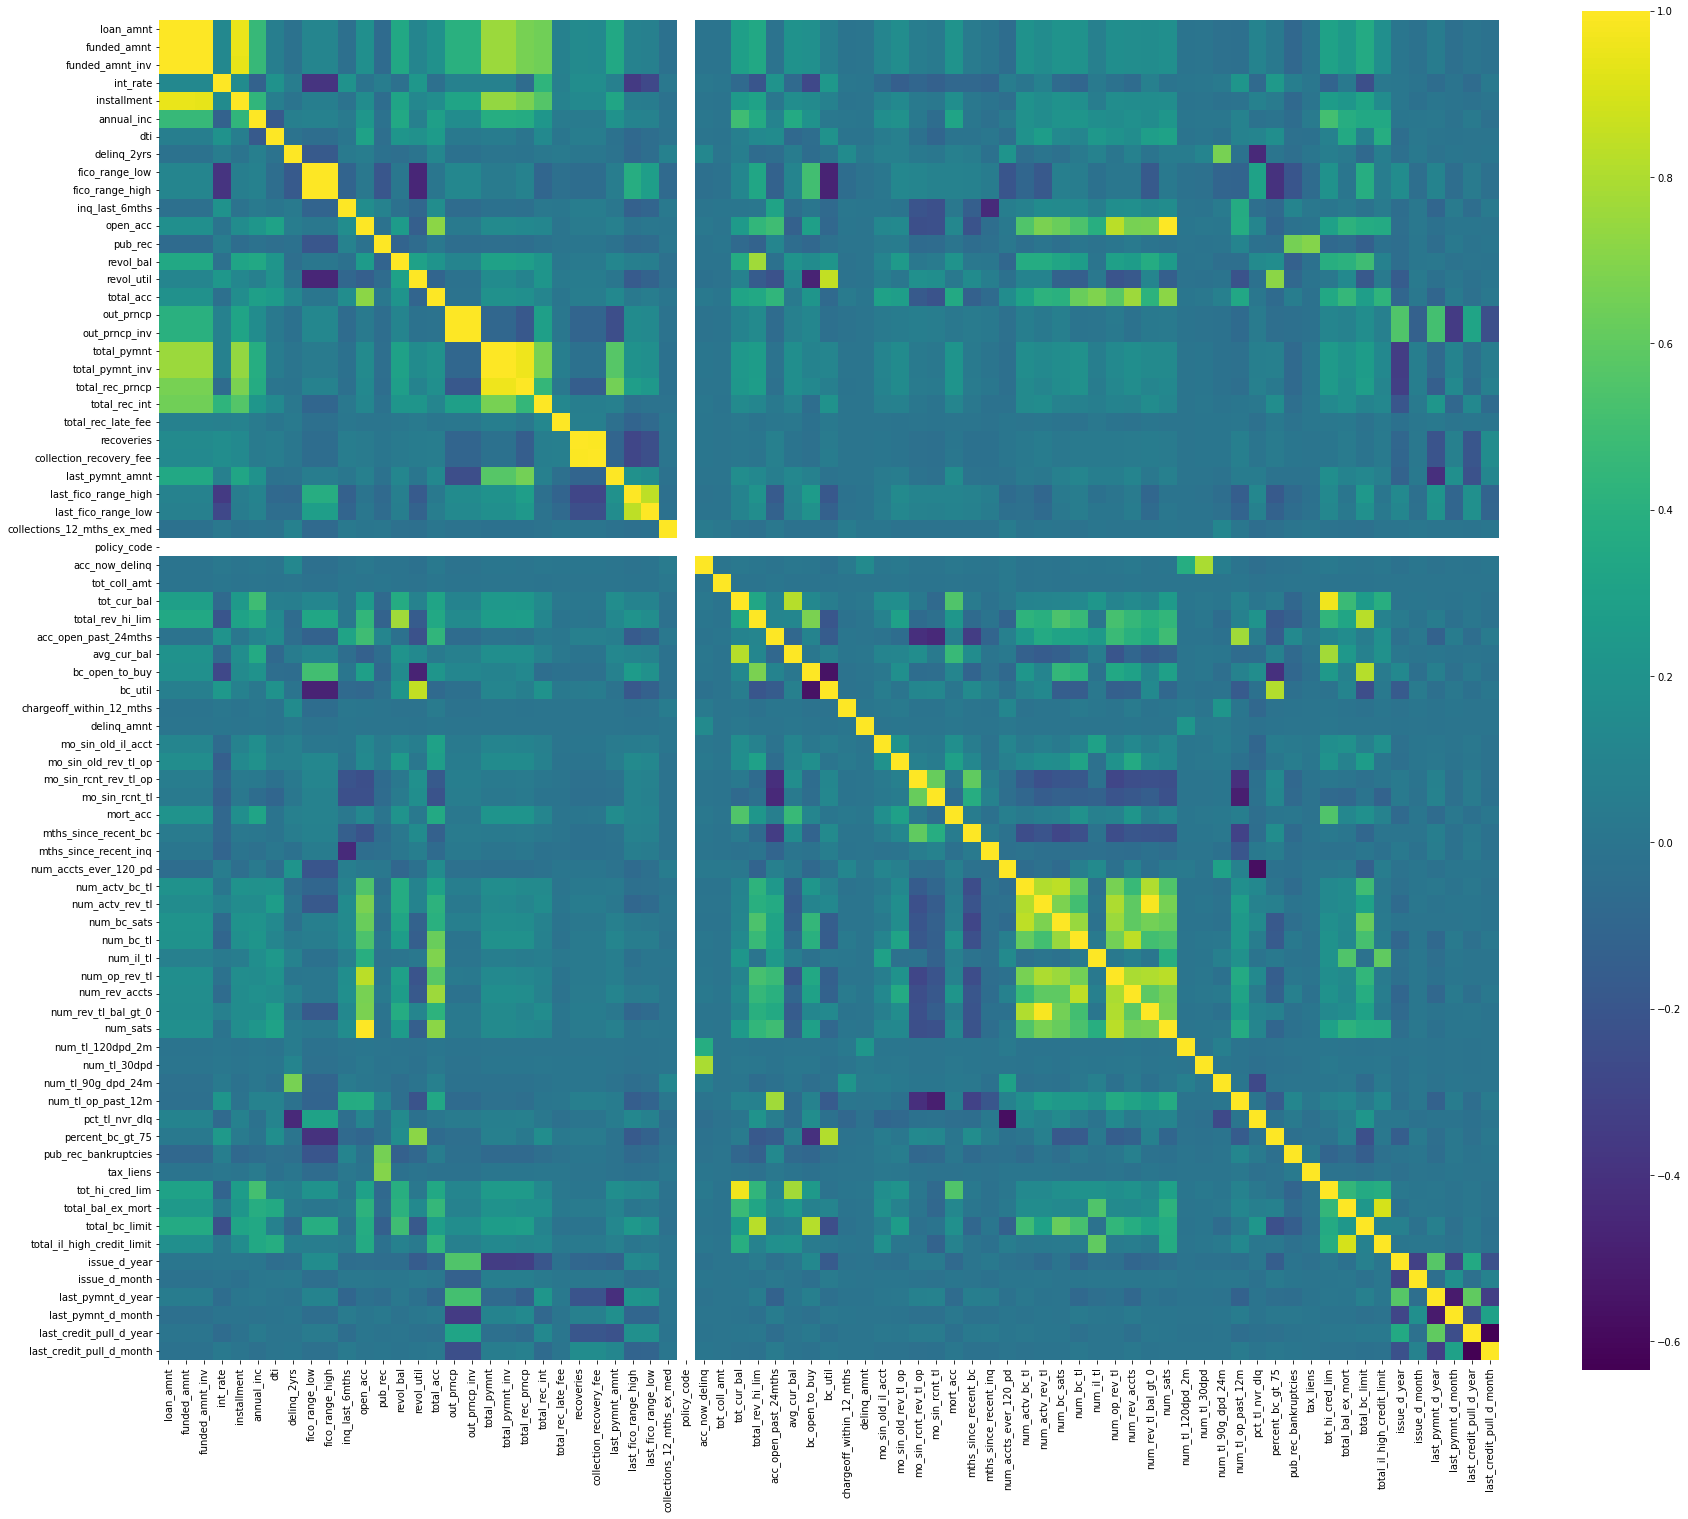

In [21]:
corr = df_nonan_outliers.corr()
plt.figure(figsize=(30,25))
sns.heatmap(corr, annot=False, cmap='viridis', square=True)

In [23]:
fig, ax = plt.subplots(figsize=(12,9))
sns.violinplot(ax=ax, x='chargeoff_within_12_mths',y='dti', data=df_nonan_outliers)

<AxesSubplot:xlabel='chargeoff_within_12_mths', ylabel='dti'>

In [24]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))


sns.distplot(df_nonan_outliers['chargeoff_within_12_mths'], ax=ax[0], color="#F7522F")
ax[0].set_title("chargeoff_within_12_mths", fontsize=14)
sns.distplot(df_nonan_outliers['collections_12_mths_ex_med'], ax=ax[1], color="#2F8FF7")
ax[1].set_title("collections_12_mths_ex_med", fontsize=14)
sns.distplot(df_nonan_outliers['recoveries'], ax=ax[2], color="#2EAD46")
ax[2].set_title("Recoveries", fontsize=14)

Text(0.5, 1.0, 'Recoveries')

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(16,5))


sns.violinplot(y='recoveries',x='collections_12_mths_ex_med', data=df_nonan_outliers, scale='count', scale_hue=False, ax=ax[0], color="#F7522F")
sns.violinplot(y='recoveries',x='chargeoff_within_12_mths', data=df_nonan_outliers, scale='count', scale_hue=False, ax=ax[1], color="#2F8FF7")

<AxesSubplot:xlabel='chargeoff_within_12_mths', ylabel='recoveries'>

<AxesSubplot:xlabel='chargeoff_within_12_mths', ylabel='collections_12_mths_ex_med'>

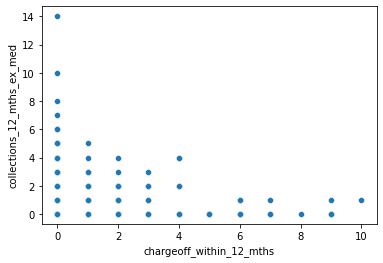

In [26]:
sns.scatterplot(y='collections_12_mths_ex_med',x='chargeoff_within_12_mths', data=df_nonan_outliers)

In [27]:
fig, ax = plt.subplots(figsize=(10,7))
sns.violinplot(ax=ax, x='loan_status',y='recoveries', data=df_nonan_outliers)

<AxesSubplot:xlabel='loan_status', ylabel='recoveries'>

In [28]:
fig, ax = plt.subplots(1, 3, figsize=(16,5))


loan_amount = df["loan_amnt"].values
funded_amount = df["funded_amnt"].values
investor_funds = df["funded_amnt_inv"].values
recoveries = df['recoveries'].values

sns.distplot(loan_amount, ax=ax[0], color="#F7522F")
ax[0].set_title("Loan Applied by the Borrower", fontsize=14)
sns.distplot(funded_amount, ax=ax[1], color="#2F8FF7")
ax[1].set_title("Amount Funded by the Lender", fontsize=14)
sns.distplot(investor_funds, ax=ax[2], color="#2EAD46")
ax[2].set_title("Total committed by Investors", fontsize=14)

Text(0.5, 1.0, 'Total committed by Investors')

Text(0, 0.5, 'Average loan amount issued')

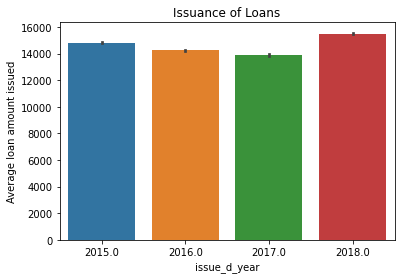

In [29]:
#plt.figure(figsize=(12,8))
sns.barplot('issue_d_year', 'loan_amnt', data=df_nonan_outliers)
plt.title('Issuance of Loans')
plt.xlabel('issue_d_year')
plt.ylabel('Average loan amount issued')

In [80]:
df_nonan['income_cat'] = np.nan
df_nonan.loc[df_nonan['annual_inc']<= 100000, 'income_cat'] = 'low'
df_nonan.loc[(df_nonan['annual_inc']> 100000) & (df_nonan['annual_inc']<= 200000), 'income_cat'] = 'medium'
df_nonan.loc[df_nonan['annual_inc']>200000, 'income_cat'] = 'high'


In [81]:
df_nonan['income_cat'].unique()

array(['low', 'medium', 'high'], dtype=object)

In [83]:
df_nonan.term.replace((' 36 months', ' 60 months'),(36 ,60), inplace = True) 
df_nonan.emp_length.replace(('10+ years','2 years','< 1 year','3 years','1 year','5 years','4 years','6 years','8 years','7 years','9 years'),(10,2,0.5,3,1,5,4,6,8,7,9), inplace  = True)

<AxesSubplot:xlabel='income_cat', ylabel='int_rate'>

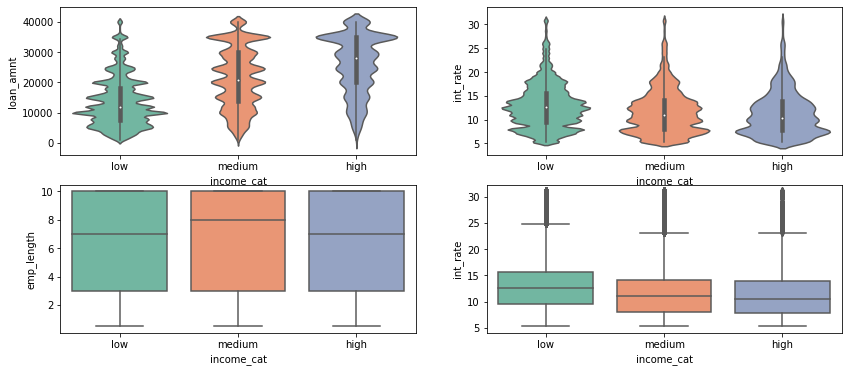

In [84]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,6))

sns.violinplot(x="income_cat", y="loan_amnt", data=df_nonan, palette="Set2", ax=ax1 )
sns.violinplot(x="income_cat", y="int_rate", data=df_nonan, palette="Set2", ax=ax2)
sns.boxplot(x="income_cat", y="emp_length", data=df_nonan, palette="Set2", ax=ax3)
sns.boxplot(x="income_cat", y="int_rate", data=df_nonan, palette="Set2", ax=ax4)

In [34]:
df_nonan_outliers = df_nonan_outliers.drop(['income_cat'], axis=1)

In [85]:
df_nonan = df_nonan.drop(['income_cat'], axis=1)

<AxesSubplot:xlabel='grade', ylabel='loan_amnt'>

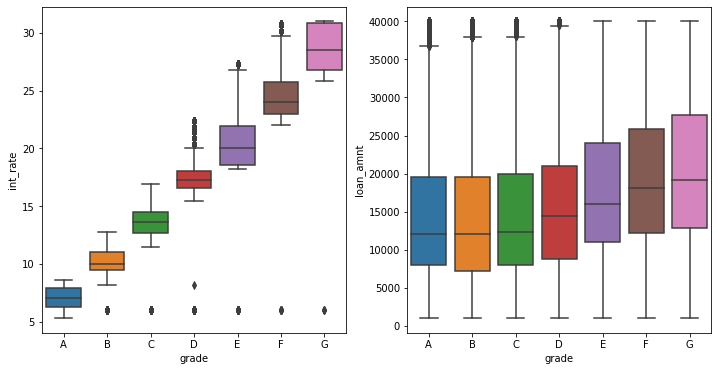

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
order = ["A", "B", "C", "D", "E", "F", "G"]
sns.boxplot(x="grade", y="int_rate", data=df_nonan_outliers, ax=ax1, order=order)
sns.boxplot(x="grade", y="loan_amnt", data=df_nonan_outliers, ax=ax2, order=order)

<AxesSubplot:xlabel='grade', ylabel='annual_inc'>

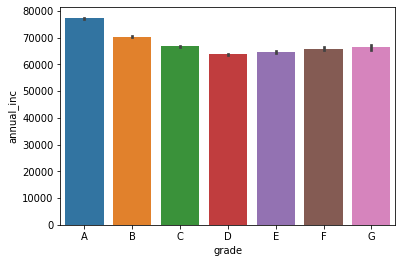

In [36]:
sns.barplot(x="grade", y="annual_inc", data=df_nonan_outliers, order=order)

In [37]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,9))
sns.boxplot(x="grade", y="fico_range_high", data=df_nonan_outliers, ax=ax1)
sns.boxplot(x="grade", y="fico_range_low", data=df_nonan_outliers, ax=ax2)

<AxesSubplot:xlabel='grade', ylabel='fico_range_low'>

In [38]:
df_nonan_outliers['annual_inc'].describe()

count    719893.000000
mean      69189.112958
std       31360.600166
min           0.000000
25%       45000.000000
50%       64000.000000
75%       88000.000000
max      162240.000000
Name: annual_inc, dtype: float64

<AxesSubplot:xlabel='annual_inc', ylabel='recoveries'>

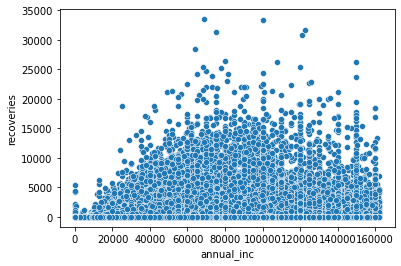

In [39]:
sns.scatterplot(y="recoveries", x="annual_inc", data=df_nonan_outliers)

In [40]:
sns.boxplot(y="recoveries", x="chargeoff_within_12_mths", data=df)

<AxesSubplot:xlabel='chargeoff_within_12_mths', ylabel='recoveries'>

In [41]:
sns.scatterplot(y="recoveries", x="chargeoff_within_12_mths", data=df)

<AxesSubplot:xlabel='chargeoff_within_12_mths', ylabel='recoveries'>

<AxesSubplot:xlabel='collection_recovery_fee', ylabel='recoveries'>

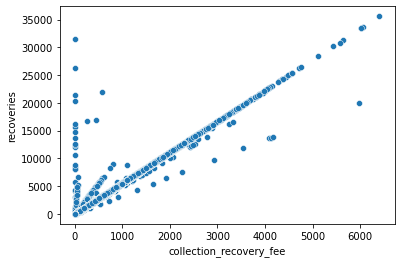

In [42]:
sns.scatterplot(x='collection_recovery_fee', y='recoveries', data=df)

## My assumption: 
- collection_recovery_fee only happens because of collection. 
- collection_recovery_fee can be greater than 0 even if chargeoff_within_12_mths and collections_12_mths_ex_med are zeros (because they could be from last year)
- Same thing is true for recoveries 
#### So I only use samples that are both charged off and collected for training purposes

In [43]:
df_nonan_outliers[(df_nonan_outliers['chargeoff_within_12_mths'] == 0)&(df_nonan_outliers['collections_12_mths_ex_med']==0)]['collection_recovery_fee'].unique()

array([  0.        , 291.402     ,  66.3066    , ..., 199.359     ,
       431.43480001, 511.00739999])

In [44]:
df_nonan_outliers[(df_nonan_outliers['chargeoff_within_12_mths'] == 0)&(df_nonan_outliers['collections_12_mths_ex_med']==0)]['recoveries'].unique()

array([   0.  , 1618.9 ,  368.37, ..., 1107.55, 2396.86, 2838.93])

In [45]:
df_nonan_outliers.isnull().sum().any()

False

In [46]:
data = df_nonan_outliers[df_nonan_outliers['loan_status']=="Charged Off"]
data = data[data['collections_12_mths_ex_med']!=0]
    
    
# Set the target variable   
data['recoveries_ratio'] = data['recoveries']/data['installment']

<AxesSubplot:xlabel='recoveries_ratio', ylabel='Count'>

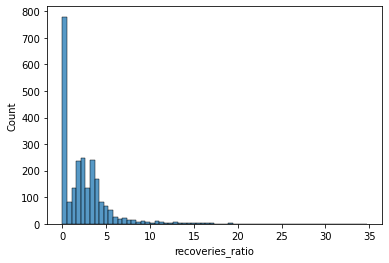

In [47]:
sns.histplot(data['recoveries_ratio'])

In [48]:
data['recoveries_ratio'].median()

2.05513766776274

In [49]:
df_nonan_outliers.shape

(719893, 89)

In [50]:
# Set the target variable   
data['y'] = np.nan
median = data['recoveries_ratio'].median() 
data.loc[data['recoveries_ratio'] > median,'y'] = 1
data.loc[data['recoveries_ratio'] <= median,'y'] = 0

X = data.drop(['recoveries','recoveries_ratio','y'], axis=1)
Y = pd.DataFrame()
Y['y'] = data['y']


### Is the data imbalanced?

With the current splits, looks like the data is balaenced enugh

In [51]:
data['y'].value_counts()

0.0    1213
1.0    1212
Name: y, dtype: int64

# Various type of classifiers

In [52]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [53]:
classifiers = [
    LogisticRegression(solver= "sag", random_state= 33, max_iter = 100),
    KNeighborsClassifier(15),
    SVC(kernel="linear"),#, probability=True),
    SVC(),#probability=True),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=100, n_estimators=180, max_features=30),
    MLPClassifier(solver='sgd', max_iter=500, learning_rate_init=0.01),
    AdaBoostClassifier(),
    GaussianNB(var_smoothing=0.02),
]
names = [
    "LogisticRegression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes"
]


## Categorical data encoded with dummies

In [54]:
# Encode the categorical features
X = pd.get_dummies(X, dtype="float64")


# Scale the data
scaler = StandardScaler()
scaler_data = scaler.fit_transform(X)

# Find the best seed to split the data
max_ = 0
best_seed = 0
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=i)#shuffle = True)
    log_model = LogisticRegression(solver= "sag", random_state= 33, max_iter = 100)
    log_model.fit(x_train,y_train)
    y_pred = log_model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    if acc > max_:
        best_seed = i
    max_ = max(max_, acc)

x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=best_seed)


accuracies_dummies = []
for name, clf in zip(names, classifiers):
    classifier = clf
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    accuracies_dummies.append(acc)
    print(f'{name} classifier acc is: {acc}')
    print(cm)

LogisticRegression classifier acc is: 0.864010989010989
[[313  46]
 [ 53 316]]
Nearest Neighbors classifier acc is: 0.5961538461538461
[[241 118]
 [176 193]]
Linear SVM classifier acc is: 0.9162087912087912
[[327  32]
 [ 29 340]]
RBF SVM classifier acc is: 0.7032967032967034
[[280  79]
 [137 232]]
Decision Tree classifier acc is: 0.9230769230769231
[[329  30]
 [ 26 343]]
Random Forest classifier acc is: 0.9326923076923077
[[332  27]
 [ 22 347]]
Neural Net classifier acc is: 0.8090659340659341
[[288  71]
 [ 68 301]]
AdaBoost classifier acc is: 0.9436813186813187
[[337  22]
 [ 19 350]]
Naive Bayes classifier acc is: 0.5068681318681318
[[102 257]
 [102 267]]


In [55]:
# fig = plt.figure(figsize=(14,9))
# ax = fig.add_axes([0,0,1,1])
# ax.bar(names, accuracies_dummies)
# ax.set_title('Performance of different classifiers')
# ax.legend(labels=['acc', 'classifier'])
# plt.show()

<AxesSubplot:>

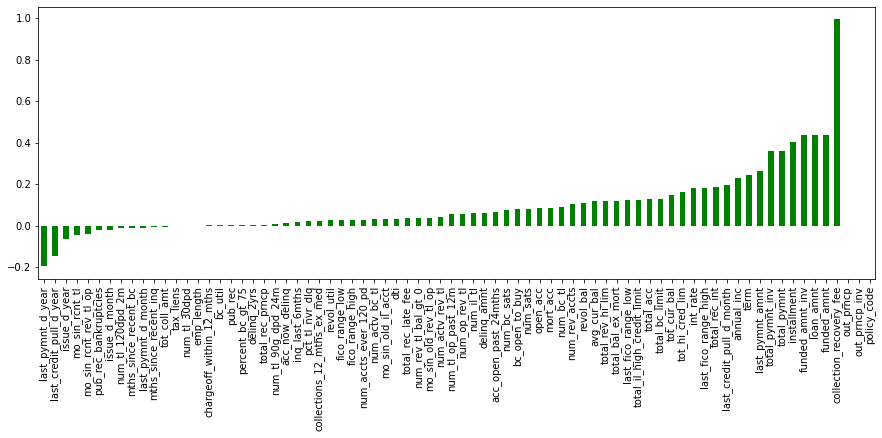

In [98]:
data.corr()['recoveries'].sort_values(ascending=True).drop(['recoveries','recoveries_ratio','y']).plot.bar(color='green', figsize=(15,5))

## Categorical data encoded with labelEncoder

In [56]:
X = data.drop(['recoveries','y','recoveries_ratio'], axis=1)

# Encode the categorical features
labelEncoder = LabelEncoder()
cat_features = X.select_dtypes(exclude="float64")

for col in cat_features:
    try:
        X[col] = labelEncoder.fit_transform(X[col]).astype('float64')
    except:
        print(col)
    

# Scale the data
scaler = StandardScaler()
scaler_data = scaler.fit_transform(X)

# Find the best seed to split the data
max_ = 0
best_seed = 0
for i in range(100):
    x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=i)#shuffle = True)
    log_model = LogisticRegression(solver= "sag", random_state= 33, max_iter = 100)
    log_model.fit(x_train,y_train)
    y_pred = log_model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    if acc > max_:
        best_seed = i
    max_ = max(max_, acc)

x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=best_seed)

accuracies_labelEncoder = []
for name, clf in zip(names, classifiers):
    classifier = clf
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    accuracies_labelEncoder.append(acc)
    print(f'{name} classifier acc is: {acc}')
    print(cm)

LogisticRegression classifier acc is: 0.9615384615384616
[[336   6]
 [ 22 364]]
Nearest Neighbors classifier acc is: 0.6895604395604396
[[245  97]
 [129 257]]
Linear SVM classifier acc is: 0.9587912087912088
[[334   8]
 [ 22 364]]
RBF SVM classifier acc is: 0.8736263736263736
[[320  22]
 [ 70 316]]
Decision Tree classifier acc is: 0.9230769230769231
[[316  26]
 [ 30 356]]
Random Forest classifier acc is: 0.9601648351648352
[[328  14]
 [ 15 371]]
Neural Net classifier acc is: 0.9271978021978022
[[325  17]
 [ 36 350]]
AdaBoost classifier acc is: 0.9574175824175825
[[333   9]
 [ 22 364]]
Naive Bayes classifier acc is: 0.7706043956043956
[[281  61]
 [106 280]]


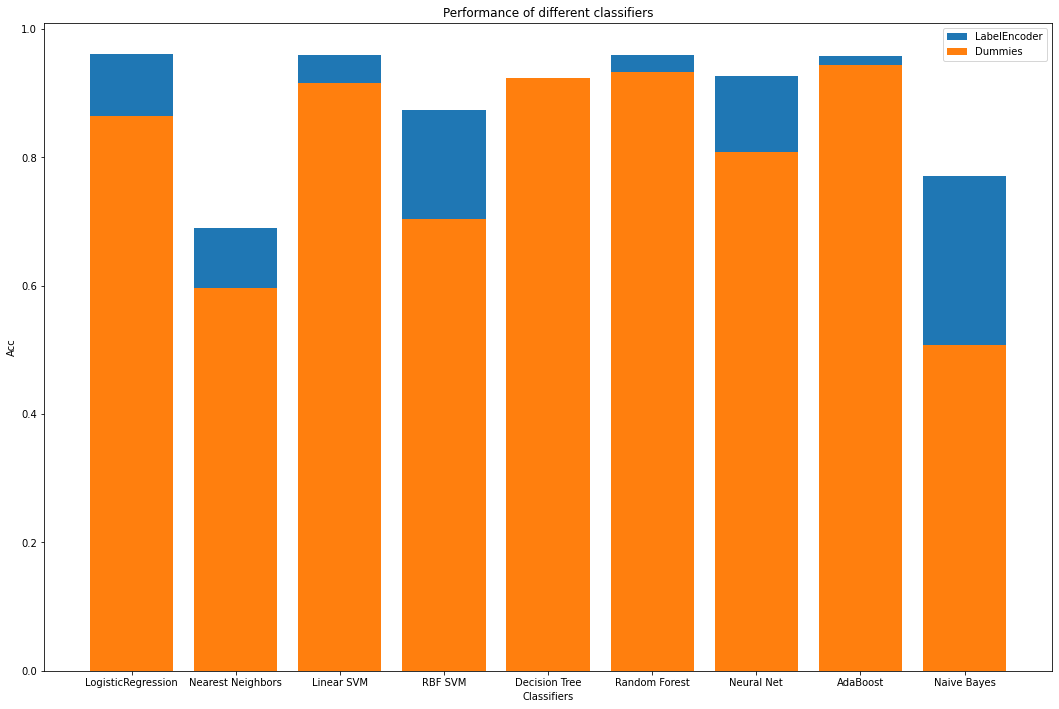

In [57]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_axes([0,0,1,1])
x_axis = np.arange(len(names))

ax.bar(names, accuracies_labelEncoder, label='LabelEncoder')
ax.bar(names, accuracies_dummies, label='Dummies')

plt.xticks(x_axis, names)
plt.xlabel("Classifiers")
plt.ylabel("Acc")
plt.title("Performance of different classifiers")
plt.legend()
plt.show()


In [58]:
X.shape

(2425, 88)

## Feature selection using correlation

<AxesSubplot:>

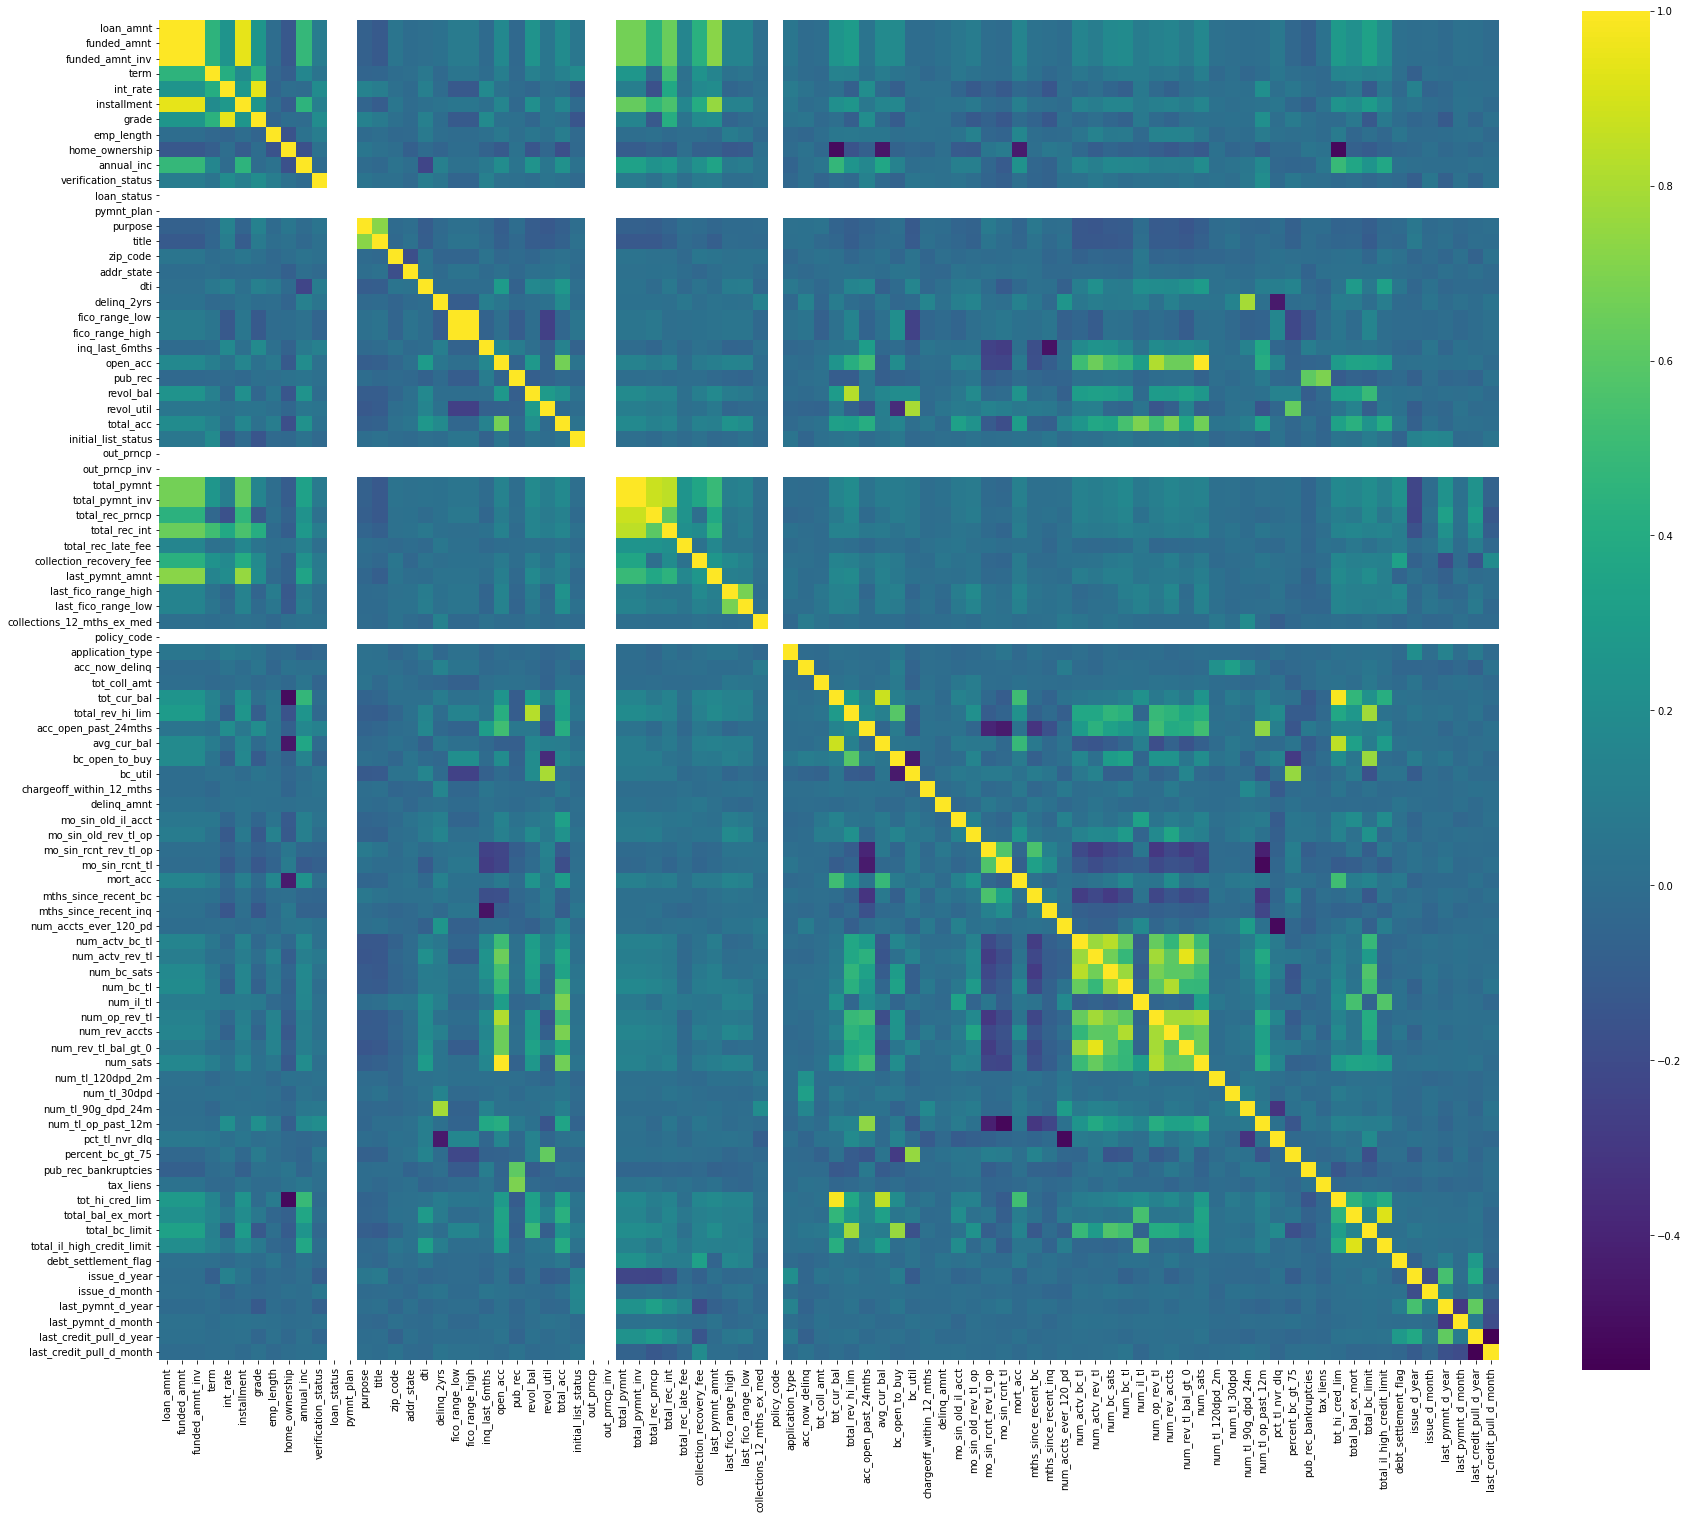

In [59]:
corr = X.corr()
plt.figure(figsize=(30,25))
sns.heatmap(corr, annot=False, cmap='viridis', square=True)

In [60]:
corr.shape

(88, 88)

In [61]:
X.shape

(2425, 88)

In [62]:
num_features = corr.shape[0]
columns = np.full((num_features,), True, dtype=bool)

for i in range(num_features):
    for j in range(i+1, num_features):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
                


In [63]:
X_FS = X[X.columns[columns]] ## X after applying feature selection

In [64]:
X_FS.shape

(2425, 78)

In [65]:
# Scale the data
scaler = StandardScaler()
scaler_data = scaler.fit_transform(X_FS)

x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=best_seed)

accuracies_labelEncoder_FS = []
for name, clf in zip(names, classifiers):
    classifier = clf
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    accuracies_labelEncoder_FS.append(acc)
    print(f'{name} classifier acc is: {acc}')
    print(cm)

LogisticRegression classifier acc is: 0.9587912087912088
[[334   8]
 [ 22 364]]
Nearest Neighbors classifier acc is: 0.6854395604395604
[[242 100]
 [129 257]]
Linear SVM classifier acc is: 0.9615384615384616
[[333   9]
 [ 19 367]]
RBF SVM classifier acc is: 0.8736263736263736
[[320  22]
 [ 70 316]]
Decision Tree classifier acc is: 0.9340659340659341
[[315  27]
 [ 21 365]]
Random Forest classifier acc is: 0.9615384615384616
[[327  15]
 [ 13 373]]
Neural Net classifier acc is: 0.9326923076923077
[[326  16]
 [ 33 353]]
AdaBoost classifier acc is: 0.9560439560439561
[[328  14]
 [ 18 368]]
Naive Bayes classifier acc is: 0.7912087912087912
[[285  57]
 [ 95 291]]


In [66]:
fig = plt.figure(figsize=(14,9))
ax = fig.add_axes([0,0,1,1])
x_axis = np.arange(len(names))

ax.bar(names, accuracies_labelEncoder, label='LabelEncoder')
ax.bar(names, accuracies_dummies, label='Dummies')
ax.bar(names, accuracies_dummies, label='FS')

plt.xticks(x_axis, names)
plt.xlabel("Classifiers")
plt.ylabel("Acc")
plt.title("Performance of different classifiers")
plt.legend()
plt.show()


## Feature selection using ExtraTreesClassifier (ETC)

In [67]:
from sklearn.ensemble import ExtraTreesClassifier

tree_model = ExtraTreesClassifier()

tree_model.fit(X, Y)
print(tree_model.feature_importances_)
print(len(tree_model.feature_importances_))

[1.13864228e-02 1.04114175e-02 1.10188118e-02 2.20816921e-02
 9.40722778e-03 9.40329101e-03 8.95912715e-03 9.40797607e-03
 7.43593595e-03 9.25276931e-03 7.81918718e-03 0.00000000e+00
 0.00000000e+00 6.40615776e-03 7.02518241e-03 8.66969886e-03
 8.68206664e-03 8.18126486e-03 7.99442681e-03 8.74463692e-03
 8.46723709e-03 8.20754522e-03 8.77515459e-03 5.63874119e-03
 7.56978165e-03 9.11274533e-03 8.10564623e-03 1.56903044e-02
 0.00000000e+00 0.00000000e+00 1.29855921e-02 1.34824195e-02
 2.64772435e-02 1.13788611e-02 5.16065882e-03 1.79134973e-01
 8.79621599e-03 1.13370059e-02 9.96348596e-03 3.56154566e-03
 0.00000000e+00 6.05833732e-04 1.07475999e-03 7.37344368e-03
 7.81168462e-03 7.79695612e-03 8.90951298e-03 7.94631241e-03
 8.15863845e-03 8.81601829e-03 2.39339181e-03 7.87494992e-04
 8.74759178e-03 8.94396340e-03 8.50551090e-03 8.43451766e-03
 7.38027733e-03 8.30672202e-03 8.63375773e-03 7.22330406e-03
 7.65016125e-03 7.86086547e-03 8.12373863e-03 7.87039306e-03
 8.15635656e-03 8.096111

In [68]:
feature_importance = pd.Series(tree_model.feature_importances_, index=X.columns)

feature_importance.nlargest(30).plot(kind='barh', figsize=(16,8))

<AxesSubplot:>

In [75]:
xETC= X[feature_importance.nlargest(40).index]


# Scale the data
scaler_data = scaler.fit_transform(xETC)


x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=best_seed)

accuracies_labelEncoder_FST = []
for name, clf in zip(names, classifiers):
    classifier = clf
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    accuracies_labelEncoder_FST.append(acc)
    print(f'{name} classifier acc is: {acc}')
    print(cm)

LogisticRegression classifier acc is: 0.9656593406593407
[[336   6]
 [ 19 367]]
Nearest Neighbors classifier acc is: 0.7637362637362637
[[266  76]
 [ 96 290]]
Linear SVM classifier acc is: 0.9752747252747253
[[339   3]
 [ 15 371]]
RBF SVM classifier acc is: 0.907967032967033
[[330  12]
 [ 55 331]]
Decision Tree classifier acc is: 0.929945054945055
[[316  26]
 [ 25 361]]
Random Forest classifier acc is: 0.9656593406593407
[[331  11]
 [ 14 372]]
Neural Net classifier acc is: 0.9505494505494505
[[329  13]
 [ 23 363]]
AdaBoost classifier acc is: 0.9532967032967034
[[331  11]
 [ 23 363]]
Naive Bayes classifier acc is: 0.8035714285714286
[[295  47]
 [ 96 290]]


### Excluding recovery fee

In [76]:
x_no_recov_fee= X[feature_importance.nlargest(40).index].drop(['collection_recovery_fee'], axis=1)

print(x_no_recov_fee.shape)

# Scale the data
scaler_data = scaler.fit_transform(x_no_recov_fee)
x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=best_seed)


accuracies_labelEncoder_FST_noRecov = []
for name, clf in zip(names, classifiers):
    classifier = clf
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    accuracies_labelEncoder_FST_noRecov.append(acc)
    print(f'{name} classifier acc is: {acc}')
    print(cm)

(2425, 39)
LogisticRegression classifier acc is: 0.9313186813186813
[[331  11]
 [ 39 347]]
Nearest Neighbors classifier acc is: 0.7087912087912088
[[246  96]
 [116 270]]
Linear SVM classifier acc is: 0.9587912087912088
[[336   6]
 [ 24 362]]
RBF SVM classifier acc is: 0.8035714285714286
[[292  50]
 [ 93 293]]
Decision Tree classifier acc is: 0.7637362637362637
[[265  77]
 [ 95 291]]
Random Forest classifier acc is: 0.8228021978021978
[[281  61]
 [ 68 318]]
Neural Net classifier acc is: 0.9010989010989011
[[322  20]
 [ 52 334]]
AdaBoost classifier acc is: 0.8214285714285714
[[287  55]
 [ 75 311]]
Naive Bayes classifier acc is: 0.6964285714285714
[[244  98]
 [123 263]]


In [77]:
sns.distplot(accuracies_dummies,label='dummies', hist=False, rug=True)
sns.distplot(accuracies_labelEncoder,label='labelEncoder', hist=False, rug=True)
sns.distplot(accuracies_labelEncoder_FS,label='feature selection', hist=False, rug=True)
sns.distplot(accuracies_labelEncoder_FST, label='tree feature selection', hist=False, rug=True)
sns.distplot(accuracies_labelEncoder_FST_noRecov,label='no recovey fee in features', hist=False, rug=True)

plt.legend()
plt.show()

## Final model

In [94]:
# Scale the data

scaler_data = scaler.fit_transform(xETC)


x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=best_seed)
classifier = RandomForestClassifier(max_depth=100, n_estimators=180, max_features=30)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
y_pred_train = classifier.predict(x_train)
train_acc = accuracy_score(y_train, y_pred_train)

print(f'Test acc is: {acc}')
print("Test confusion matrix:")
print(cm)
print(f'Train acc is: {train_acc}')

Test acc is: 0.9692513368983957
Test confusion matrix:
[[384  10]
 [ 13 341]]
Train acc is: 1.0


## Evaluation on a few examples

In [97]:
data.shape

(2491, 91)

In [98]:
X.shape

(2491, 88)

In [99]:
x_test.shape

(748, 30)

In [102]:
import random
#random.seed(101)

samples = 10
indexes = []
recoveries = []
predictions = []

labelEncoder = LabelEncoder()

for i in range(samples):
    random_ind = random.randint(0,len(data))
    print(random_ind)
    new_customer = scaler_data[random_ind]
    
    recoveries.append(data.iloc[random_ind]['recoveries'])
    
    new_customer = new_customer.reshape(1,30)
    predictions.append(classifier.predict(new_customer))
    
    indexes.append(random_ind)

415
1369
29
1223
77
1166
1018
785
1195
1962


In [103]:
for i, val in enumerate(recoveries):
    print(val, predictions[i], indexes[i])

588.0 [1.] 415
1484.0 [1.] 1369
902.97 [1.] 29
357.81 [0.] 1223
2428.98 [1.] 77
0.0 [0.] 1166
1862.23 [1.] 1018
346.77 [0.] 785
731.8 [1.] 1195
3378.28 [1.] 1962


In [138]:
data.iloc[785]['recoveries_ratio']

1.6017090069284063

In [139]:
data.iloc[785]['y']

0.0

## Additional ideas
- Explore non-linear regression
- CNN
- Explore semi-supervised approaches

# Trying a regression model

In [99]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor

In [87]:
reg_data = df_nonan_outliers[df_nonan['loan_status']=="Charged Off"]
reg_data = reg_data[reg_data['collections_12_mths_ex_med']!=0]

labelEncoder = LabelEncoder()
cat_features = reg_data.select_dtypes(exclude="float64")

for col in cat_features:
    try:
        reg_data[col] = labelEncoder.fit_transform(reg_data[col]).astype('float64')
    except:
        print(col)

In [339]:
X = reg_data.drop(['recoveries','id','sub_grade', 'url'], axis=1)
X = scaler.fit_transform(X)
y = reg_data['recoveries']

In [345]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.30, random_state=best_seed)

reg_model = linear_model.LinearRegression()
reg_model.fit(x_train,y_train)
y_pred = reg_model.predict(x_test)
#cm = confusion_matrix(y_test, y_pred)
#acc = accuracy_score(y_test, y_pred)
#print(f'acc is: {acc}')
#print(cm)

In [346]:
reg_model.score(X,y)

-0.518288674656096

In [347]:
reg_model.intercept_

array([0.49601427])

In [348]:
reg_model.coef_

array([[ 3.61197436e+11, -3.61197436e+11, -2.07308960e+00,
         9.67712402e-02, -7.41653442e-02,  1.16844177e-01,
        -1.08032227e-02,  5.68389893e-03, -2.55584717e-04,
        -1.75971985e-02,  8.71276855e-03,  1.37519836e-03,
        -2.58865356e-02, -1.01776123e-02,  3.01742554e-03,
         5.79833984e-04,  2.26993561e-02, -8.74710083e-03,
        -1.62706375e-02, -2.06756592e-03,  1.21212006e-02,
         5.49316406e-04, -1.60980225e-03, -2.37531662e-02,
        -3.66210938e-02, -5.29766083e-04, -4.75311279e-02,
         3.12447548e-02, -1.44691467e-01,  2.40478516e-02,
         6.37674332e-03,  1.49192810e-02, -2.06701660e+00,
         3.90328979e+00, -1.17277145e+00, -6.31034851e-01,
        -1.07746124e-02, -2.13996887e-01,  2.28881836e-04,
        -8.84628296e-03,  1.91612244e-02,  3.49903107e-03,
         1.28364563e-02, -1.18026733e-02,  3.97491455e-03,
         7.57598877e-03, -9.55657959e-02,  4.37927246e-02,
         2.87513733e-02,  1.45797729e-02, -1.34391785e-0

# custom CNN model

In [132]:
import tensorflow as tf

In [155]:
inputs = tf.keras.Input(shape=(x_train.shape[1],))
x = tf.keras.layers.Dense(64, activation='relu')(inputs)
x = tf.keras.layers.Dense(64, activation='relu')(x)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)


model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)


batch_size = 64
epochs = 50

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
)

92
Epoch 1/50
21/21 [==============================] - 0s 6ms/step - loss: 0.6700 - accuracy: 0.5876 - val_loss: 0.6118 - val_accuracy: 0.7006
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.6012 - accuracy: 0.6886 - val_loss: 0.5616 - val_accuracy: 0.7515
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5618 - accuracy: 0.7141 - val_loss: 0.5307 - val_accuracy: 0.7635
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5322 - accuracy: 0.7425 - val_loss: 0.5041 - val_accuracy: 0.7754
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5051 - accuracy: 0.7627 - val_loss: 0.4837 - val_accuracy: 0.7844
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4822 - accuracy: 0.7740 - val_loss: 0.4652 - val_accuracy: 0.8024
Epoch 7/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4601 - accuracy: 0.7897 - val_loss: 0.4507 - val_accuracy: 0.7874
Epoch 8/50
21/21 

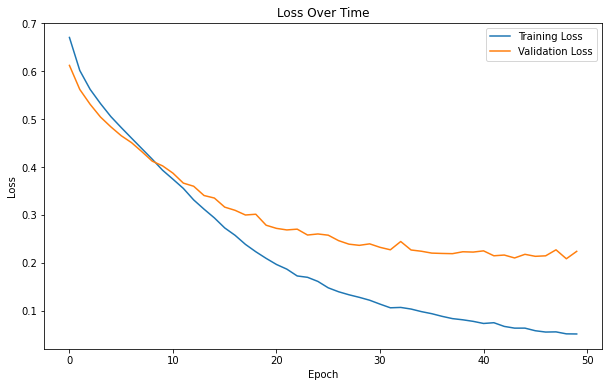

In [157]:
plt.figure(figsize=(10, 6))

epochs_range = range(epochs)
train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Time")
plt.legend()

plt.show()

In [216]:
model.predict(x_test)

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1586 predict_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1576 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1569 run_step  **
        outputs = model.predict_step(data)
    /opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1537 predict_step
        return self(x, training=False)
    /opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py:1020 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /opt/conda/lib/python3.7/site-packages/keras/engine/input_spec.py:254 assert_input_compatibility
        ' but received input with shape ' + display_shape(x.shape))

    ValueError: Input 0 of layer sequential is incompatible with the layer: expected axis -1 of input shape to have value 92 but received input with shape (None, 20)


In [163]:
confusion_matrix(y_test, model.predict(x_test).argmax(axis=-1))

array([[352,   0],
       [364,   0]])

In [171]:
y_train.shape

(1670, 1)

In [176]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [177]:
model = Sequential()
# input layer
model.add(Dense(68,  activation='relu'))
model.add(Dropout(0.2))
# hidden layer
model.add(Dense(34, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(17, activation='relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(units=1,activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam')

In [178]:
scaler_data = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=best_seed)
history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[tf.keras.callbacks.ReduceLROnPlateau()]
)
model.save('model.h5') 

Epoch 1/50
21/21 [==============================] - 0s 6ms/step - loss: 0.7183 - val_loss: 0.6714
Epoch 2/50
21/21 [==============================] - 0s 2ms/step - loss: 0.6723 - val_loss: 0.6441
Epoch 3/50
21/21 [==============================] - 0s 2ms/step - loss: 0.6320 - val_loss: 0.6072
Epoch 4/50
21/21 [==============================] - 0s 2ms/step - loss: 0.6043 - val_loss: 0.5552
Epoch 5/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5515 - val_loss: 0.5069
Epoch 6/50
21/21 [==============================] - 0s 2ms/step - loss: 0.5101 - val_loss: 0.4668
Epoch 7/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4701 - val_loss: 0.4416
Epoch 8/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4330 - val_loss: 0.4229
Epoch 9/50
21/21 [==============================] - 0s 2ms/step - loss: 0.4025 - val_loss: 0.4043
Epoch 10/50
21/21 [==============================] - 0s 2ms/step - loss: 0.3760 - val_loss: 0.3866
Epoch 11/50
21/21 [

In [179]:
losses = pd.DataFrame(model.history.history)

In [180]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

In [183]:
predictions = model.predict(x_test).argmax(axis=-1)

In [185]:
from sklearn.metrics import classification_report
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

         0.0       0.49      1.00      0.66       352
         1.0       0.00      0.00      0.00       364

    accuracy                           0.49       716
   macro avg       0.25      0.50      0.33       716
weighted avg       0.24      0.49      0.32       716



In [186]:
confusion_matrix(y_test,predictions)

array([[352,   0],
       [364,   0]])

In [187]:
data.shape

(2386, 97)

In [574]:
collected[collected['loan_status']=='Charged Off']['recoveries'].value_counts()

0.00       748
150.00       8
200.00       6
50.00        4
100.00       4
          ... 
1440.17      1
1860.34      1
784.02       1
503.63       1
1610.69      1
Name: recoveries, Length: 1715, dtype: int64

In [596]:
sns.scatterplot(x='tot_coll_amt', y='recoveries', data=df)

<AxesSubplot:xlabel='tot_coll_amt', ylabel='recoveries'>

In [597]:
df.shape

(761993, 153)

In [590]:
no_collections['recoveries'].unique()

array([   0.  , 1618.9 ,  368.37, ..., 1107.55, 2396.86, 2838.93])

In [591]:
no_collections['collections_12_mths_ex_med'].unique()

array([0.])

In [592]:
no_collections['chargeoff_within_12_mths'].unique()

array([0., 1., 2., 3., 6., 7., 4., 5., 9., 8.])

In [595]:
df[df['chargeoff_within_12_mths']==0]['recoveries'].unique()

array([   0.  , 1618.9 ,  368.37, ..., 8258.84, 2396.86, 2838.93])

In [598]:
collected.shape

(14228, 153)

In [413]:
no_collections.shape

(747765, 151)

In [414]:
collected['recoveries'].plot(kind='line', ylim=(0,35000))

<AxesSubplot:>

<AxesSubplot:>

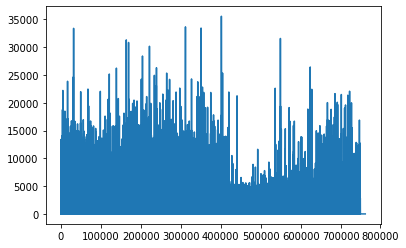

In [416]:
no_collections['recoveries'].plot(kind='line')

- When income increases the recoveries reduces. Maybe because with good income, charged off does not happen often

In [575]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7,ax8)) = plt.subplots(nrows=4, ncols=2, figsize=(16,8))
sns.violinplot(x="income_cat", y="recoveries", hue='grade', data=df, palette="Set2", ax=ax1 )
#sns.catplot(x="income_cat", y="recoveries", hue='grade', data=df, palette="Set2", ax=ax1  )
sns.boxplot(x="income_cat", y="recoveries", data=df, palette="Set2", ax=ax2 )

sns.violinplot(x="income_cat", y="collections_12_mths_ex_med", data=df, palette="Set2", ax=ax3)
sns.boxplot(x="income_cat", y="collections_12_mths_ex_med", data=df, palette="Set2", ax=ax4)

sns.violinplot(x="income_cat", y="chargeoff_within_12_mths", data=df, palette="Set2", ax=ax5)
sns.boxplot(x="income_cat", y="chargeoff_within_12_mths", data=df, palette="Set2", ax=ax6)

sns.violinplot(x="income_cat", y="avg_cur_bal", data=df, palette="Set2", ax=ax7)
sns.boxplot(x="income_cat", y="avg_cur_bal", data=df, palette="Set2", ax=ax8)

<AxesSubplot:xlabel='income_cat', ylabel='avg_cur_bal'>

In [603]:
df['chargeoff_within_12_mths'].value_counts()

0.0     755613
1.0       5855
2.0        383
3.0         80
4.0         25
5.0         10
6.0          7
9.0          5
7.0          4
8.0          1
10.0         1
Name: chargeoff_within_12_mths, dtype: int64

<AxesSubplot:>

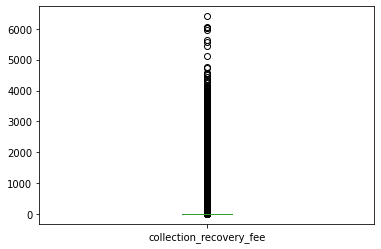

In [110]:
df['collection_recovery_fee'].plot(kind='box')

In [111]:
df['collection_recovery_fee'].describe()

count    761984.000000
mean         30.573089
std         147.522298
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        6404.738400
Name: collection_recovery_fee, dtype: float64

In [114]:
iqr = df['collection_recovery_fee'].quantile(0.75)-df['collection_recovery_fee'].quantile(0.25)
df['collection_recovery_fee'].quantile(0.75) + 1.5*iqr

In [116]:
iqr = df['annual_inc'].quantile(0.75)-df['annual_inc'].quantile(0.25)
df['annual_inc'].quantile(0.75) + 1.5*iqr

162250.0

In [117]:
df['annual_inc'].plot(kind='box')

<AxesSubplot:>

8 loan_amnt -10000.0 38000.0
8 funded_amnt -10000.0 38000.0
8 funded_amnt_inv -10000.0 38000.0
8 term 0.0 96.0
8 int_rate -0.1899999999999995 24.77
8 installment -247.52999999999992 1093.35
49555 emp_length -10.0 22.0
8 annual_inc -23750.0 162250.0
0 pymnt_plan 0.0 0.0
490 dti -7.15 44.61
8 delinq_2yrs 0.0 0.0
8 fico_range_low 602.5 782.5
8 fico_range_high 606.5 786.5
8 inq_last_6mths -1.5 2.5
378935 mths_since_last_delinq -35.0 101.0
633554 mths_since_last_record 2.0 138.0
8 open_acc -2.5 25.5
8 pub_rec 0.0 0.0
8 revol_bal -15851.5 42440.5
513 revol_util -24.149999999999984 125.84999999999998
8 total_acc -6.5 53.5
8 out_prncp -5907.6 9846.0
8 out_prncp_inv -5904.975 9841.625
8 total_pymnt -12839.810000000005 36875.87000000001
8 total_pymnt_inv -12833.710000000003 36860.61
8 total_rec_prncp -12500.0 31500.0
8 total_rec_int -3014.885 7266.835000000001
8 total_rec_late_fee 0.0 0.0
8 recoveries 0.0 0.0
9 collection_recovery_fee 0.0 0.0
9 last_pymnt_amnt -6024.635000000001 10889.565
9 last

In [605]:
pd.get_dummies(df_income['home_ownership'],prefix='home_ownership')

home_ownership_ANY  home_ownership_MORTGAGE  home_ownership_NONE  \
0                        0                        1                    0   
1                        0                        1                    0   
2                        0                        1                    0   
3                        0                        1                    0   
4                        0                        1                    0   
...                    ...                      ...                  ...   
761988                   0                        0                    0   
761989                   0                        0                    0   
761990                   0                        0                    0   
761991                   0                        1                    0   
761992                   0                        1                    0   

        home_ownership_OWN  home_ownership_RENT  
0                        0                    0  
1                        0                    0  
2                        0                    0  
3                        0                    0  
4                        0                    0  
...                    ...                  ...  
761988                   0                    1  
761989                   0                    1  
761990                   0                    1  
761991                   0                    0  
761992                   0                    0  

[761909 rows x 5 columns]

In [520]:
df_income['home_ownership'].unique()

array(['MORTGAGE', 'RENT', 'OWN', 'ANY', 'NONE'], dtype=object)

In [518]:
df['fico_range_high'].unique()

array([679., 719., 699., 789., 694., 684., 709., 689., 704., 714., 724.,
       669., 749., 804., 729., 839., 784., 664., 734., 754., 674., 744.,
       759., 799., 779., 774., 769., 739., 794., 819., 850., 764., 809.,
       814., 829., 824., 844., 834.,  nan])

In [519]:
df['fico_range_low'].unique()

array([675., 715., 695., 785., 690., 680., 705., 685., 700., 710., 720.,
       665., 745., 800., 725., 835., 780., 660., 730., 750., 670., 740.,
       755., 795., 775., 770., 765., 735., 790., 815., 845., 760., 805.,
       810., 825., 820., 840., 830.,  nan])

In [526]:
df_income[['fico_range_high','fico_range_low', 'loan_amnt', 'grade', 'recoveries', 'issue_d']].iloc[0,:]

fico_range_high                  679.0
fico_range_low                   675.0
loan_amnt                       3600.0
grade                                C
recoveries                         0.0
issue_d            2015-12-01 00:00:00
Name: 0, dtype: object

In [528]:
df['year'].unique()

array([2015.,   nan, 2018., 2017., 2016.])

In [473]:
df.groupby('grade')['annual_inc']

In [468]:
df['annual_inc']

0          55000.0
1          65000.0
2          63000.0
3         110000.0
4         104433.0
            ...   
761988     50000.0
761989     75000.0
761990     65000.0
761991     62500.0
761992     56000.0
Name: annual_inc, Length: 761993, dtype: float64

In [418]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761993 entries, 0 to 761992
Columns: 151 entries, id to settlement_term
dtypes: datetime64[ns](9), float64(113), object(29)
memory usage: 877.8+ MB


In [419]:
df.isnull().any()

id                       False
member_id                 True
loan_amnt                 True
funded_amnt               True
funded_amnt_inv           True
                         ...  
settlement_status         True
settlement_date           True
settlement_amount         True
settlement_percentage     True
settlement_term           True
Length: 151, dtype: bool

In [420]:
df.isnull().sum()

id                            0
member_id                761993
loan_amnt                     8
funded_amnt                   8
funded_amnt_inv               8
                          ...  
settlement_status        746551
settlement_date          746551
settlement_amount        746551
settlement_percentage    746551
settlement_term          746551
Length: 151, dtype: int64

In [351]:
data = df_nonan_outliers[df_nonan['loan_status']=="Charged Off"]
data = data[data['collections_12_mths_ex_med']!=0]

labelEncoder = LabelEncoder()
cat_features = data.select_dtypes(exclude="float64")

for col in cat_features:
    try:
        data[col] = labelEncoder.fit_transform(data[col]).astype('float64')
    except:
        print(col)
# Scale the data

data['recoveries_ratiio'] = data['recoveries']/data['installment']

data['y'] = np.nan
median = data['recoveries_ratiio'].median() 
data.loc[data['recoveries_ratiio'] > median,'y'] = 1
data.loc[data['recoveries_ratiio'] <= median,'y'] = 0

X = data.drop(['recoveries', 'recoveries_ratiio','y','id','sub_grade', 'url'], axis=1)
Y = pd.DataFrame()
Y['y'] = data['y']

scaler_data = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=best_seed)

#classifier = LogisticRegression(solver= "sag", random_state= 33, max_iter = 100)
#classifier = GaussianProcessClassifier(1.0 * RBF(1.0))
classifier = RandomForestClassifier(max_depth=100, n_estimators=180, max_features=30)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
y_pred_train = classifier.predict(x_train)
train_acc = accuracy_score(y_train, y_pred_train)

print(f'Test acc is: {acc}')
print("Test confusion matrix:")
print(cm)
print(f'Train acc is: {train_acc}')

(2386, 92)

## Without scaling the data

In [979]:
#x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.23, shuffle=True)
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size = 0.30, random_state=best_seed)
classifier = SVC(kernel="linear", C=0.025)
classifier.fit(x_train,y_train)
y_pred = classifier.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(f'acc is: {acc}')
print(cm)

acc is: 0.972
[[353   7]
 [ 14 376]]


## Fine tuning the models

In [144]:
classifiers = [
    LogisticRegression(solver= "sag", random_state= 43, max_iter = 100),
    KNeighborsClassifier(15),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5, criterion='entropy'),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]
names = [
    "LogisticRegression",
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

In [145]:
x_no_recov_fee= X[feature_importance.nlargest(20).index].drop(['collection_recovery_fee'], axis=1)

# Scale the data
scaler_data = scaler.fit_transform(x_no_recov_fee)
x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.30, random_state=best_seed)


accuracies_labelEncoder_FST_noRecov = []
for name, clf in zip(names, classifiers):
    classifier = clf
    classifier.fit(x_train,y_train)
    y_pred = classifier.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    accuracies_labelEncoder_FST_noRecov.append(acc)
    print(f'{name} classifier acc is: {acc}')
    print(cm)

LogisticRegression classifier acc is: 0.9385474860335196
[[328  24]
 [ 20 344]]
Nearest Neighbors classifier acc is: 0.7625698324022346
[[262  90]
 [ 80 284]]
Linear SVM classifier acc is: 0.8198324022346368
[[287  65]
 [ 64 300]]
RBF SVM classifier acc is: 0.5991620111731844
[[325  27]
 [260 104]]
Gaussian Process classifier acc is: 0.9762569832402235
[[344   8]
 [  9 355]]
Decision Tree classifier acc is: 0.7849162011173184
[[274  78]
 [ 76 288]]
Random Forest classifier acc is: 0.7374301675977654
[[250 102]
 [ 86 278]]
Neural Net classifier acc is: 0.9427374301675978
[[333  19]
 [ 22 342]]
AdaBoost classifier acc is: 0.8254189944134078
[[291  61]
 [ 64 300]]
Naive Bayes classifier acc is: 0.7122905027932961
[[244 108]
 [ 98 266]]
QDA classifier acc is: 0.5
[[334  18]
 [340  24]]


# Data exploration

In [431]:
!pip install imblearn

     |████████████████████████████████| 189 kB 4.5 MB/s eta 0:00:01


In [924]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE

import statistics
import warnings
warnings.filterwarnings('ignore')

%matplotlib.inline


UsageError: Line magic function `%matplotlib.inline` not found.


In [393]:
df_noDate = pd.read_csv('accepted_2007_to_2018Q4.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [394]:
df_noDate.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'hardship_payoff_balance_amount', 'hardship_last_payment_amount',
       'disbursement_method', 'debt_settlement_flag',
       'debt_settlement_flag_date', 'settlement_status', 'settlement_date',
       'settlement_amount', 'settlement_percentage', 'settlement_term'],
      dtype='object', length=151)

In [395]:
for c in df_noDate.columns:
    if c[-2:]=='_d' or c[-5:]=='_date':
        print(c)

issue_d
last_pymnt_d
next_pymnt_d
last_credit_pull_d
hardship_start_date
hardship_end_date
payment_plan_start_date
debt_settlement_flag_date
settlement_date


In [396]:
df_noDate['settlement_date'].unique()

array([nan, 'Sep-2017', 'Nov-2017', 'Jan-2018', 'May-2018', 'Jun-2018',
       'Jul-2018', 'Mar-2018', 'Apr-2018', 'Jan-2019', 'Dec-2017',
       'Dec-2018', 'Apr-2017', 'Aug-2018', 'Aug-2017', 'Mar-2017',
       'Feb-2018', 'Oct-2018', 'May-2017', 'Sep-2018', 'Oct-2017',
       'Feb-2017', 'Feb-2019', 'Jul-2017', 'Mar-2019', 'Nov-2018',
       'Jun-2017', 'Jan-2017', 'Jun-2016', 'Aug-2016', 'Nov-2016',
       'Dec-2016', 'Sep-2016', 'Apr-2016', 'Jul-2016', 'Oct-2016',
       'May-2016', 'Mar-2016', 'Feb-2016', 'Jan-2016', 'Dec-2015',
       'Oct-2015', 'Sep-2015', 'Aug-2015', 'Nov-2015', 'Jun-2015',
       'Jul-2015', 'May-2015'], dtype=object)

In [398]:
df_noDate.shape

(761993, 151)

In [818]:
df = pd.read_csv('accepted_2007_to_2018Q4.csv', parse_dates=['issue_d', 'last_pymnt_d',\
                                                             'next_pymnt_d', 'last_credit_pull_d', \
                                                             'hardship_start_date', 'hardship_end_date',\
                                                             'payment_plan_start_date',\
                                                             'debt_settlement_flag_date',\
                                                             'settlement_date'])

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (0,19,59,118,129,130,131,139,146) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [784]:
parsed_dates=['issue_d', 'last_pymnt_d',\
             'next_pymnt_d', 'last_credit_pull_d', \
             'hardship_start_date', 'hardship_end_date',\
             'payment_plan_start_date',\
             'debt_settlement_flag_date',\
             'settlement_date']

In [785]:
for col in parsed_dates: 
    df[col] = df[col].values.astype('datetime64[D]')

In [399]:
df.shape

(761993, 151)

In [400]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761993 entries, 0 to 761992
Columns: 151 entries, id to settlement_term
dtypes: datetime64[ns](9), float64(113), object(29)
memory usage: 877.8+ MB


In [401]:
df.describe()

member_id      loan_amnt    funded_amnt  funded_amnt_inv  \
count        0.0  761985.000000  761985.000000    761985.000000   
mean         NaN   15220.176316   15220.139570     15214.745953   
std          NaN    9074.014274    9074.016323      9071.450377   
min          NaN    1000.000000    1000.000000       750.000000   
25%          NaN    8000.000000    8000.000000      8000.000000   
50%          NaN   13400.000000   13400.000000     13400.000000   
75%          NaN   20000.000000   20000.000000     20000.000000   
max          NaN   40000.000000   40000.000000     40000.000000   

            int_rate   installment    annual_inc            dti  \
count  761985.000000  761985.00000  7.619850e+05  761503.000000   
mean       12.700238     445.49571  7.770800e+04      19.289750   
std         4.709280     262.03695  1.468898e+05      14.130075   
min         5.310000      14.01000  0.000000e+00       0.000000   
25%         9.170000     255.30000  4.600000e+04      12.260000   
50%        12.290000     380.66000  6.500000e+04      18.340000   
75%        15.410000     590.52000  9.250000e+04      25.200000   
max        30.990000    1719.83000  1.100000e+08     999.000000   

         delinq_2yrs  fico_range_low  ...  deferral_term  hardship_amount  \
count  761985.000000   761985.000000  ...         4587.0      4587.000000   
mean        0.330673      697.229735  ...            3.0       141.714327   
std         0.911280       32.599198  ...            0.0       123.908602   
min         0.000000      660.000000  ...            3.0         0.640000   
25%         0.000000      670.000000  ...            3.0        51.185000   
50%         0.000000      690.000000  ...            3.0       108.170000   
75%         0.000000      715.000000  ...            3.0       195.330000   
max        39.000000      845.000000  ...            3.0       943.940000   

       hardship_length  hardship_dpd  \
count           4587.0   4587.000000   
mean               3.0     14.068672   
std                0.0      9.598678   
min                3.0      0.000000   
25%                3.0      6.000000   
50%                3.0     15.000000   
75%                3.0     22.500000   
max                3.0     31.000000   

       orig_projected_additional_accrued_interest  \
count                                 3674.000000   
mean                                   418.263593   
std                                    363.183250   
min                                      1.920000   
25%                                    151.927500   
50%                                    322.710000   
75%                                    573.622500   
max                                   2680.890000   

       hardship_payoff_balance_amount  hardship_last_payment_amount  \
count                     4587.000000                   4587.000000   
mean                     10863.098901                    188.794365   
std                       7378.003986                    192.092835   
min                         55.730000                      0.010000   
25%                       5037.725000                     43.585000   
50%                       9300.080000                    129.600000   
75%                      15123.100000                    278.205000   
max                      40306.410000                   1290.590000   

       settlement_amount  settlement_percentage  settlement_term  
count       15442.000000           15442.000000     15442.000000  
mean         4991.678873              47.657693        13.445473  
std          3655.458202               6.486543         7.695430  
min           107.000000               0.450000         0.000000  
25%          2186.400000              45.000000         8.000000  
50%          4205.200000              45.000000        14.000000  
75%          6864.935000              50.000000        18.000000  
max         30000.000000             166.670000       112.000000  

[8 rows x 113 columns]

<AxesSubplot:ylabel='disbursement_method'>

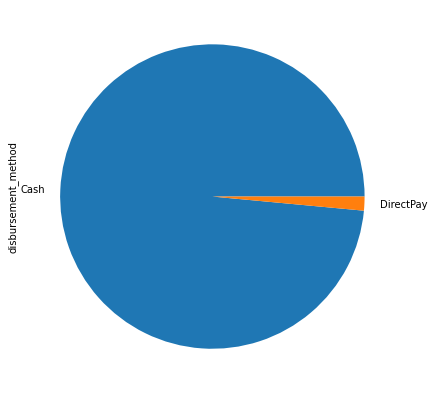

In [421]:
df['disbursement_method'].value_counts().plot(kind='pie', figsize=(16, 7))

In [422]:
df['debt_settlement_flag'].value_counts().plot(kind='pie', figsize=(16, 7))

<AxesSubplot:ylabel='debt_settlement_flag'>

In [145]:
sns.scatterplot(x='collection_recovery_fee', y='chargeoff_within_12_mths', data=df)

<AxesSubplot:xlabel='collection_recovery_fee', ylabel='chargeoff_within_12_mths'>

<AxesSubplot:xlabel='collection_recovery_fee', ylabel='collections_12_mths_ex_med'>

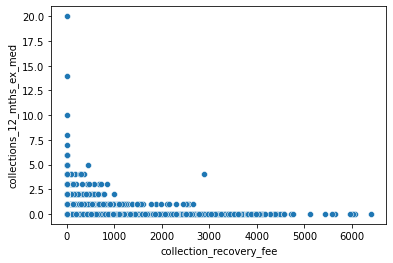

In [146]:
sns.scatterplot(x='collection_recovery_fee', y='collections_12_mths_ex_med', data=df)

#### As expected, the higher the value for charged off per past 12 month, the lower the recoveries and recovery fee

<AxesSubplot:xlabel='chargeoff_within_12_mths', ylabel='collection_recovery_fee'>

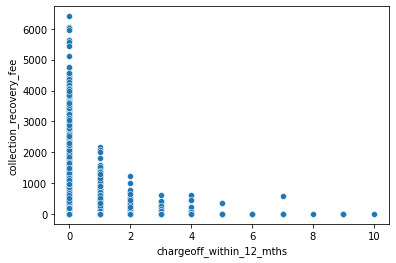

In [583]:
sns.scatterplot(y='collection_recovery_fee', x='chargeoff_within_12_mths', data=df)

<AxesSubplot:xlabel='chargeoff_within_12_mths', ylabel='collections_12_mths_ex_med'>

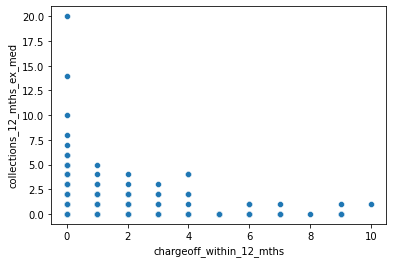

In [584]:
sns.scatterplot(y='collections_12_mths_ex_med', x='chargeoff_within_12_mths', data=df)

<AxesSubplot:xlabel='chargeoff_within_12_mths', ylabel='recoveries'>

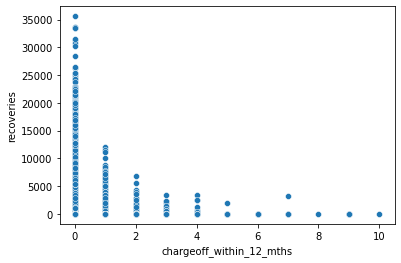

In [582]:
sns.scatterplot(y='recoveries', x='chargeoff_within_12_mths', data=df)

<AxesSubplot:xlabel='collections_12_mths_ex_med', ylabel='recoveries'>

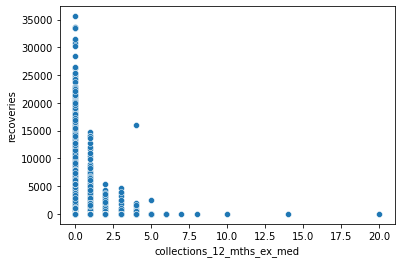

In [581]:
sns.scatterplot(y='recoveries', x='collections_12_mths_ex_med', data=df)

<AxesSubplot:xlabel='grade', ylabel='recoveries'>

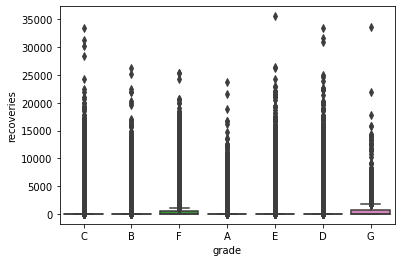

In [404]:
sns.boxplot(x='grade', y='recoveries', data=df)

<AxesSubplot:xlabel='collections_12_mths_ex_med', ylabel='Count'>

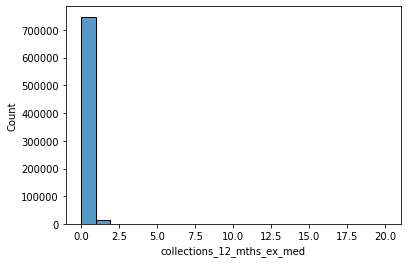

In [405]:
sns.histplot(x='collections_12_mths_ex_med',data=df)

<AxesSubplot:ylabel='collections_12_mths_ex_med'>

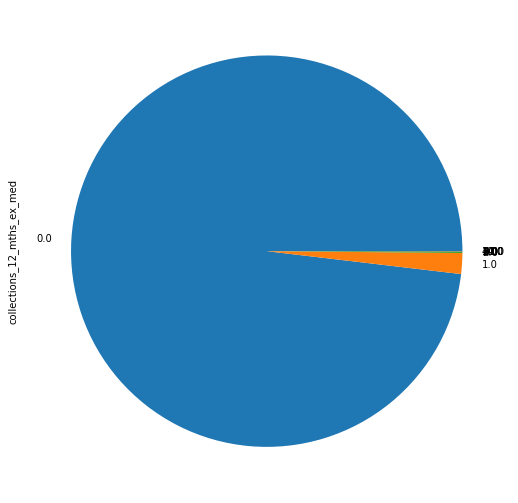

In [406]:
df['collections_12_mths_ex_med'].value_counts().plot(kind='pie',figsize=(12,9))

In [407]:
df['collections_12_mths_ex_med'].value_counts()

0.0     747765
1.0      13114
2.0        926
3.0        122
4.0         37
5.0         12
6.0          3
8.0          1
14.0         1
10.0         1
7.0          1
20.0         1
Name: collections_12_mths_ex_med, dtype: int64

<AxesSubplot:title={'center':'no collection in 12 month'}, ylabel='loan_status'>

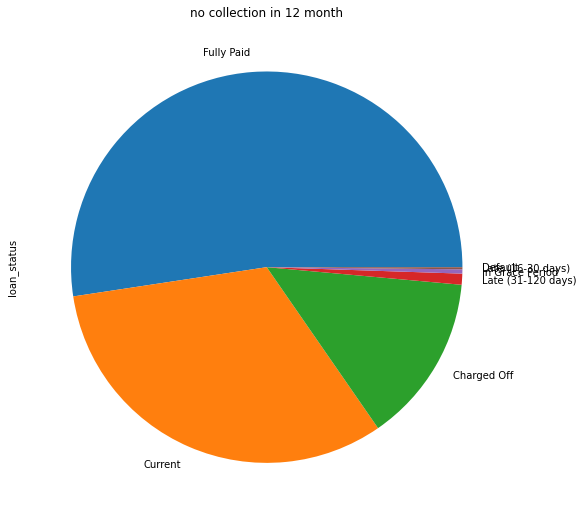

In [569]:
no_collections = df[df['collections_12_mths_ex_med']==0]
no_collections['loan_status'].value_counts().plot(kind='pie', figsize=(12, 9),title="no collection in 12 month")

<AxesSubplot:title={'center':'collected in 12 month'}, ylabel='loan_status'>

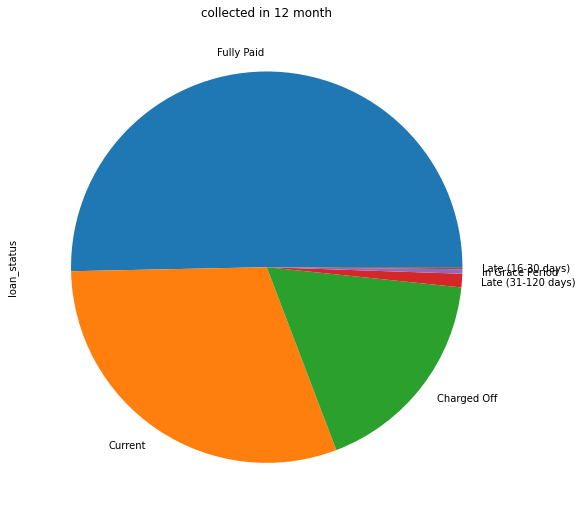

In [570]:
collected = df[df['collections_12_mths_ex_med']!=0]
collected['loan_status'].value_counts().plot(kind='pie', figsize=(12, 9),title="collected in 12 month")

## Removing irrelevant features and encode categorical ones

In [622]:
df.select_dtypes(include='object')

grade                    emp_title home_ownership verification_status  \
0          C                      leadman       MORTGAGE        Not Verified   
1          C                     Engineer       MORTGAGE        Not Verified   
2          B                 truck driver       MORTGAGE        Not Verified   
3          C  Information Systems Officer       MORTGAGE     Source Verified   
4          F          Contract Specialist       MORTGAGE     Source Verified   
...      ...                          ...            ...                 ...   
761988     B             shift supervisor           RENT     Source Verified   
761989     A                   Recruiter            RENT            Verified   
761990     C              Forklift driver           RENT     Source Verified   
761991     A                          NaN       MORTGAGE        Not Verified   
761992     A                      Teacher       MORTGAGE            Verified   

       loan_status pymnt_plan desc             purpose  \
0       Fully Paid          n  NaN  debt_consolidation   
1       Fully Paid          n  NaN      small_business   
2       Fully Paid          n  NaN    home_improvement   
3          Current          n  NaN  debt_consolidation   
4       Fully Paid          n  NaN      major_purchase   
...            ...        ...  ...                 ...   
761988     Current          n  NaN  debt_consolidation   
761989     Current          n  NaN         credit_card   
761990     Current          n  NaN  debt_consolidation   
761991     Current          n  NaN         credit_card   
761992     Current          n  NaN         credit_card   

                          title application_type verification_status_joint  \
0            Debt consolidation       Individual                       NaN   
1                      Business       Individual                       NaN   
2                           NaN        Joint App              Not Verified   
3            Debt consolidation       Individual                       NaN   
4                Major purchase       Individual                       NaN   
...                         ...              ...                       ...   
761988       Debt consolidation       Individual                       NaN   
761989  Credit card refinancing        Joint App                  Verified   
761990       Debt consolidation       Individual                       NaN   
761991  Credit card refinancing       Individual                       NaN   
761992  Credit card refinancing              NaN                       NaN   

       sec_app_earliest_cr_line hardship_reason hardship_status  \
0                           NaN             NaN             NaN   
1                           NaN             NaN             NaN   
2                           NaN             NaN             NaN   
3                           NaN             NaN             NaN   
4                           NaN             NaN             NaN   
...                         ...             ...             ...   
761988                      NaN             NaN             NaN   
761989                 Mar-2007             NaN             NaN   
761990                      NaN             NaN             NaN   
761991                      NaN             NaN             NaN   
761992                      NaN             NaN             NaN   

       hardship_loan_status settlement_status income_cat  
0                       NaN               NaN        low  
1                       NaN               NaN        low  
2                       NaN               NaN        low  
3                       NaN               NaN     medium  
4                       NaN               NaN     medium  
...                     ...               ...        ...  
761988                  NaN               NaN        low  
761989                  NaN               NaN        low  
761990                  NaN               NaN        low  
761991           

In [824]:
binary_features = ['pymnt_plan', 'application_type']
le = LabelEncoder()
for col in binary_features:
    df[col] = le.fit_transform(df[col])
    
df.term.replace((' 36 months', ' 60 months'),(36 ,60), inplace = True) 
df.emp_length.replace(('10+ years','2 years','< 1 year','3 years','1 year',\
                       '5 years','4 years','6 years','8 years','7 years','9 years')\
                      ,(10,2,0.5,3,1,5,4,6,8,7,9), inplace  = True)

In [820]:
df.select_dtypes(include='object')

id grade sub_grade                    emp_title home_ownership  \
0        68407277     C        C4                      leadman       MORTGAGE   
1        68355089     C        C1                     Engineer       MORTGAGE   
2        68341763     B        B4                 truck driver       MORTGAGE   
3        66310712     C        C5  Information Systems Officer       MORTGAGE   
4        68476807     F        F1          Contract Specialist       MORTGAGE   
...           ...   ...       ...                          ...            ...   
761988  140558551     B        B4             shift supervisor           RENT   
761989  140001150     A        A2                   Recruiter            RENT   
761990  140425954     C        C3              Forklift driver           RENT   
761991  139043619     A        A3                          NaN       MORTGAGE   
761992  140648733     A        A1                      Teacher       MORTGAGE   

       verification_status loan_status  \
0             Not Verified  Fully Paid   
1             Not Verified  Fully Paid   
2             Not Verified  Fully Paid   
3          Source Verified     Current   
4          Source Verified  Fully Paid   
...                    ...         ...   
761988     Source Verified     Current   
761989            Verified     Current   
761990     Source Verified     Current   
761991        Not Verified     Current   
761992            Verified     Current   

                                                      url desc  \
0       https://lendingclub.com/browse/loanDetail.acti...  NaN   
1       https://lendingclub.com/browse/loanDetail.acti...  NaN   
2       https://lendingclub.com/browse/loanDetail.acti...  NaN   
3       https://lendingclub.com/browse/loanDetail.acti...  NaN   
4       https://lendingclub.com/browse/loanDetail.acti...  NaN   
...                                                   ...  ...   
761988  https://lendingclub.com/browse/loanDetail.acti...  NaN   
761989  https://lendingclub.com/browse/loanDetail.acti...  NaN   
761990  https://lendingclub.com/browse/loanDetail.acti...  NaN   
761991  https://lendingclub.com/browse/loanDetail.acti...  NaN   
761992  https://lendingclub.com/browse/loanDetail.acti...  NaN   

                   purpose  ... verification_status_joint  \
0       debt_consolidation  ...                       NaN   
1           small_business  ...                       NaN   
2         home_improvement  ...              Not Verified   
3       debt_consolidation  ...                       NaN   
4           major_purchase  ...                       NaN   
...                    ...  ...                       ...   
761988  debt_consolidation  ...                       NaN   
761989         credit_card  ...                  Verified   
761990  debt_consolidation  ...                       NaN   
761991         credit_card  ...                       NaN   
761992         credit_card  ...                       NaN   

       sec_app_earliest_cr_line hardship_flag hardship_type hardship_reason  \
0                           NaN             N           NaN             NaN   
1                           NaN             N           NaN             NaN   
2                           NaN             N           NaN             NaN   
3                           NaN             N           NaN             NaN   
4                           NaN             N           NaN             NaN   
...                         ...           ...           ...             ...   
761988                      NaN             N           NaN             NaN   
761989                 Mar-2007             N           NaN             NaN   
761990                      NaN             N           NaN             NaN   
761991                      NaN             N           NaN             NaN   
761992                      NaN           NaN           NaN             NaN   

       hardship_status hardship_loan_status disbursement_metho

In [823]:
# df.drop(columns=['id','member_id','sub_grade', 'issue_d', 'url', 'earliest_cr_line', \
#                        'last_pymnt_d', 'last_credit_pull_d','zip_code', 'addr_state', \
#                        'initial_list_status','hardship_flag', 'hardship_type', 'disbursement_method', \
#                        'debt_settlement_flag','desc' ], inplace=True)

df = pd.read_csv('accepted_2007_to_2018Q4.csv', parse_dates=['issue_d', 'last_pymnt_d',\
                                                             'next_pymnt_d', 'last_credit_pull_d', \
                                                             'hardship_start_date', 'hardship_end_date',\
                                                             'payment_plan_start_date',\
                                                             'debt_settlement_flag_date',\
                                                             'settlement_date'])
df.drop(columns=['id','member_id','sub_grade', 'url', 'earliest_cr_line', \
                       'zip_code', 'addr_state', \
                       'initial_list_status','hardship_flag', 'hardship_type', 'disbursement_method', \
                       'debt_settlement_flag','desc' ], inplace=True)
df.drop(columns=parsed_dates, inplace=True)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (0,19,59,118,129,130,131,139,146) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [789]:
df.select_dtypes(include='object')

grade                    emp_title home_ownership verification_status  \
0          C                      leadman       MORTGAGE        Not Verified   
1          C                     Engineer       MORTGAGE        Not Verified   
2          B                 truck driver       MORTGAGE        Not Verified   
3          C  Information Systems Officer       MORTGAGE     Source Verified   
4          F          Contract Specialist       MORTGAGE     Source Verified   
...      ...                          ...            ...                 ...   
761988     B             shift supervisor           RENT     Source Verified   
761989     A                   Recruiter            RENT            Verified   
761990     C              Forklift driver           RENT     Source Verified   
761991     A                          NaN       MORTGAGE        Not Verified   
761992     A                      Teacher       MORTGAGE            Verified   

       loan_status             purpose                    title  \
0       Fully Paid  debt_consolidation       Debt consolidation   
1       Fully Paid      small_business                 Business   
2       Fully Paid    home_improvement                      NaN   
3          Current  debt_consolidation       Debt consolidation   
4       Fully Paid      major_purchase           Major purchase   
...            ...                 ...                      ...   
761988     Current  debt_consolidation       Debt consolidation   
761989     Current         credit_card  Credit card refinancing   
761990     Current  debt_consolidation       Debt consolidation   
761991     Current         credit_card  Credit card refinancing   
761992     Current         credit_card  Credit card refinancing   

       verification_status_joint sec_app_earliest_cr_line hardship_reason  \
0                            NaN                      NaN             NaN   
1                            NaN                      NaN             NaN   
2                   Not Verified                      NaN             NaN   
3                            NaN                      NaN             NaN   
4                            NaN                      NaN             NaN   
...                          ...                      ...             ...   
761988                       NaN                      NaN             NaN   
761989                  Verified                 Mar-2007             NaN   
761990                       NaN                      NaN             NaN   
761991                       NaN                      NaN             NaN   
761992                       NaN                      NaN             NaN   

       hardship_status hardship_loan_status settlement_status  
0                  NaN                  NaN               NaN  
1                  NaN                  NaN               NaN  
2                  NaN                  NaN               NaN  
3                  NaN                  NaN               NaN  
4                  NaN                  NaN               NaN  
...                ...                  ...               ...  
761988             NaN                  NaN               NaN  
761989             NaN                  NaN               NaN  
761990             NaN                  NaN               NaN  
761991             NaN                  NaN               NaN  
761992             NaN                  NaN               NaN  

[761993 rows x 13 columns]

In [825]:
df.shape

(761993, 129)

In [282]:
df_nonan_outliers.iloc[551102]

id                           115701924
loan_amnt                       8000.0
funded_amnt                     8000.0
funded_amnt_inv                 8000.0
term                         36 months
                               ...    
issue_d_month                      8.0
last_pymnt_d_year               2019.0
last_pymnt_d_month                 3.0
last_credit_pull_d_year         2019.0
last_credit_pull_d_month           3.0
Name: 579864, Length: 96, dtype: object

In [283]:
df_nonan_outliers.iloc[62455]

id                            63752346
loan_amnt                      12000.0
funded_amnt                    12000.0
funded_amnt_inv                12000.0
term                         36 months
                               ...    
issue_d_month                     11.0
last_pymnt_d_year               2018.0
last_pymnt_d_month                10.0
last_credit_pull_d_year         2019.0
last_credit_pull_d_month           3.0
Name: 65862, Length: 96, dtype: object

### Separate numeric from object feature

In [200]:
df_nonan_objects = df_nonan.select_dtypes(include='object')
df_nonan_float = df_nonan.select_dtypes(exclude='object')


In [259]:
df_nonan_objects.columns

Index(['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')

In [201]:
df_nonan_objects.shape

(761993, 24)

In [202]:
df_nonan_float.shape

(761993, 69)

In [212]:
selected_columns = df_nonan_float.columns[columns]
numeric_data = df_nonan_float[selected_columns]

In [855]:
corr.index

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low',
       'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       '

In [854]:
numeric_data.columns

Index(['loan_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
       'fico_range_low', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'revol_util', 'total_acc', 'out_prncp', 'total_pymnt', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'last_pymnt_amnt',
       'last_fico_range_high', 'last_fico_range_low',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim',
       'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct',
       'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl',
       'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_accts', 'num_tl_120dpd_2m', 'num_tl_30dpd',
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl

In [859]:
df_nonan_float['delinq_2yrs'].unique()

array([ 0.,  1.,  2.,  3.,  4.,  6.,  5., 15.,  7.,  9., 10.,  8., 11.,
       13., 14., 12., 30., 18., 16., 17., 26., 20., 19., 22., 27., 39.,
       28., 21., 25., 32.])

<AxesSubplot:>

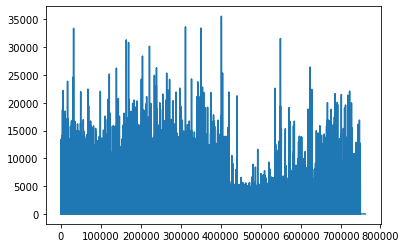

In [220]:
numeric_data['recoveries'].plot(kind='line')

In [224]:
X = numeric_data.drop('recoveries', axis=1)

In [225]:
numeric_data.shape

(761993, 56)

In [226]:
X.shape

(761993, 55)

In [227]:
Y = pd.DataFrame()
Y['recoveries'] = numeric_data['recoveries']

In [229]:
Y[Y['recoveries'] != 0] = 1 

In [231]:
Y.value_counts()

recoveries
0.0           691662
1.0            70331
dtype: int64

In [48]:
df_nonan['debt_settlement_flag'].value_counts()  ## looks like the data is imbalanced

N    746551
Y     15442
Name: debt_settlement_flag, dtype: int64

### Logestic regression model on numeric features only

In [239]:
scaler = StandardScaler()
scaler_data = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(scaler_data,Y,test_size = 0.25, shuffle = True)
log_model = LogisticRegression(solver= "sag", random_state= 33, max_iter = 100)
log_model.fit(x_train,y_train)

#model score with train data
print(log_model.score(x_train,y_train))

#model score with test data
print(log_model.score(x_test,y_test))

y_pred = log_model.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
print(cm)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9333361330127701
0.9337581824576507
[[168048   4955]
 [  7664   9832]]


## Feature selection using ExtraTreesClassifier (ETC)

In [254]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
model.fit(scaler_data, Y)
print(model.feature_importances_)
print(len(model.feature_importances_))


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


[4.60882154e-02 2.51249644e-02 1.24356426e-02 1.26993645e-02
 7.22965053e-03 1.47430883e-02 9.38306812e-03 1.15863938e-02
 6.34692935e-03 1.17577187e-02 1.24444591e-02 1.26693734e-02
 6.31697274e-02 4.73898902e-02 2.16703836e-02 1.12958544e-02
 5.87633675e-02 1.41407819e-01 1.58503984e-01 2.19444992e-03
 0.00000000e+00 5.57297877e-04 7.55306431e-03 1.14533903e-02
 1.19200042e-02 1.31348526e-02 1.14984249e-02 1.20373082e-02
 1.11983546e-03 4.70536510e-04 1.22533136e-02 1.27543484e-02
 1.17850478e-02 1.18847966e-02 1.04987523e-02 1.18199902e-02
 1.21941368e-02 8.06007340e-03 1.10269437e-02 1.14516824e-02
 1.09769646e-02 1.21468615e-02 1.19058290e-02 1.13667645e-02
 1.24074338e-02 1.11161689e-04 3.85125290e-04 3.70965553e-03
 1.17516569e-02 1.06155895e-02 1.15882147e-02 5.64031871e-03
 2.99905711e-03 1.18134847e-02 1.22037380e-02]
55


<AxesSubplot:>

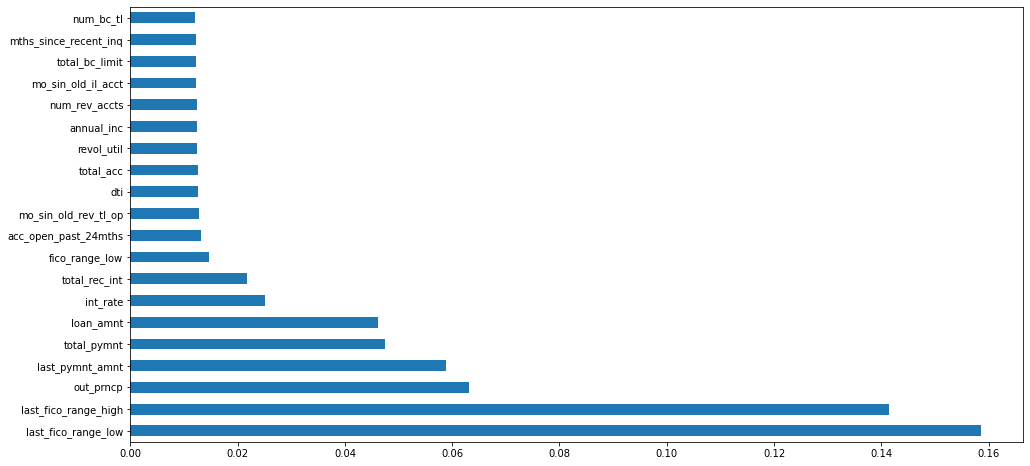

In [255]:
feature_importance = pd.Series(model.feature_importances_, index=X.columns)

feature_importance.nlargest(20).plot(kind='barh', figsize=(16,8))

### Logestic regression model on top 20 important numeric features 

In [279]:
xETC= X[feature_importance.nlargest(20).index]
scaler_data_ETC = scaler.fit_transform(xETC)
x_train_ETC, x_test_ETC, y_train_ETC, y_test_ETC = train_test_split(scaler_data_ETC,Y,test_size = 0.25, shuffle = True)
log_model_ETC = LogisticRegression(solver= "sag", random_state= 33, max_iter = 100)
log_model_ETC.fit(x_train_ETC,y_train_ETC)

#model score with train data
print(log_model_ETC.score(x_train_ETC,y_train_ETC))

#model score with test data
print(log_model_ETC.score(x_test_ETC,y_test_ETC))

y_pred_ETC = log_model_ETC.predict(x_test_ETC)
cm_ETC = confusion_matrix(y_test_ETC, y_pred_ETC)
print(cm_ETC)

/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9329581762888149
0.9337109381151607
[[168026   4946]
 [  7682   9845]]


## Including categorical values

In [288]:
df_nonan_less_objects = df_nonan_objects.drop(columns=['id', 'sub_grade', 'issue_d', 'url', 'earliest_cr_line', \
                       'last_credit_pull_d','zip_code', 'addr_state', \
                       'initial_list_status','hardship_flag', 'disbursement_method'])

In [295]:
df_nonan_less_objects.term.replace((' 36 months', ' 60 months'),(36 ,60), inplace = True) 
df_nonan_less_objects.emp_length.replace(('10+ years','2 years','< 1 year','3 years','1 year','5 years','4 years','6 years','8 years','7 years','9 years'),(10,2,0.5,3,1,5,4,6,8,7,9), inplace  = True)
#df_nonan_less_objects.grade.replace(('A', 'B', 'C', 'D', 'E', 'F', 'G'),(0,1,2,3,4,5,6), inplace = True) 
#df_nonan_less_objects.home_ownership.replace(('MORTGAGE', 'RENT','OWN','ANY', 'OTHER','NONE'),(1,2,3,4,5,6), inplace = True) 
#df_nonan_less_objects.verification_status.replace(('Source Verified', 'Verified','Not Verified'),(1,2,3), inplace = True) 
#df_nonan_less_objects.loan_status.replace(('Fully Paid', 'Charged Off', 'Current','Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)', 'Default'),(0,1,2,3,4,5,6), inplace = True)
#df_nonan_less_objects.pymnt_plan.replace(('n', 'y'),(0,1), inplace = True) 
#df_nonan_less_objects.purpose.replace(('debt_consolidation', 'credit_card','home_improvement','other', 'major_purchase','medical','small_business','car','moving','vacation','house','wedding','renewable_energy','educational'),(1,2,3,4,5,6,7,8,9,10,11,12,13,14), inplace = True) 
#df_nonan_less_objects.application_type.replace(('Individual','Joint App'),(1,2), inplace  = True)

In [300]:
categorical_features = df_nonan_less_objects.columns
one_hot_encoded_data = numeric_data
print(categorical_features)

Index(['term', 'grade', 'emp_title', 'emp_length', 'home_ownership',
       'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'title',
       'last_pymnt_d', 'application_type', 'debt_settlement_flag'],
      dtype='object')


In [301]:
df_nonan_less_objects['emp_length'].value_counts()

10.0    303187
2.0      68695
0.5      64599
3.0      60866
1.0      50196
5.0      45749
4.0      45509
8.0      32987
6.0      31338
7.0      30549
9.0      28318
Name: emp_length, dtype: int64

In [306]:
label_encoder = LabelEncoder()
for column in categorical_features:
    df_nonan_less_objects[column] = label_encoder.fit_transform(df_nonan_less_objects[column]).astype('float64')
    


In [307]:
df_nonan_less_objects.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761993 entries, 0 to 761992
Data columns (total 13 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   term                  761993 non-null  float64
 1   grade                 761993 non-null  float64
 2   emp_title             761993 non-null  float64
 3   emp_length            761993 non-null  float64
 4   home_ownership        761993 non-null  float64
 5   verification_status   761993 non-null  float64
 6   loan_status           761993 non-null  float64
 7   pymnt_plan            761993 non-null  float64
 8   purpose               761993 non-null  float64
 9   title                 761993 non-null  float64
 10  last_pymnt_d          761993 non-null  float64
 11  application_type      761993 non-null  float64
 12  debt_settlement_flag  761993 non-null  float64
dtypes: float64(13)
memory usage: 75.6 MB


In [308]:
df_nonan_less_objects.shape

(761993, 13)

In [309]:
numeric_data.shape

(761993, 56)

In [ ]:
numeric_data_extra = pd.merge(left=numeric_data,
        right=df_nonan_less_objects,
        left_index=True,
        right_index=True,)

In [ ]:
numeric_data_extra

<AxesSubplot:xlabel='recoveries', ylabel='Count'>

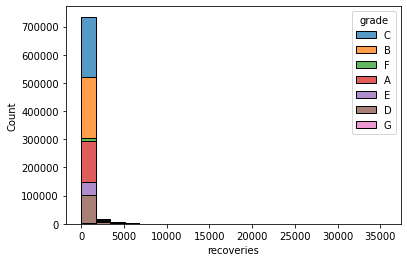

In [278]:
sns.histplot(data=df_nonan, x='recoveries', hue='grade', multiple="stack")

In [273]:
a = df_nonan[df_nonan['grade']=='G']['recoveries'].values

In [274]:
b = df_nonan[df_nonan['grade']=='A']['recoveries'].values

In [258]:
df_nonan[df_nonan['loan_status']=='Fully Paid']['recoveries'].value_counts()

0.0    398914
Name: recoveries, dtype: int64

In [260]:
df_nonan_objects.columns

Index(['id', 'term', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'verification_status', 'issue_d', 'loan_status',
       'pymnt_plan', 'url', 'purpose', 'title', 'zip_code', 'addr_state',
       'earliest_cr_line', 'initial_list_status', 'last_pymnt_d',
       'last_credit_pull_d', 'application_type', 'hardship_flag',
       'disbursement_method', 'debt_settlement_flag'],
      dtype='object')

<AxesSubplot:ylabel='grade'>

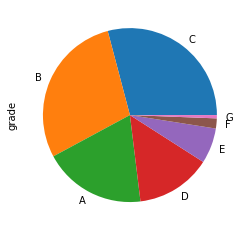

In [49]:
df_nonan['grade'].value_counts().plot(kind='pie')

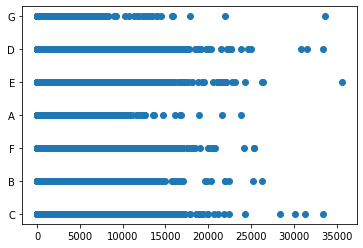

In [50]:
plt.scatter(df_nonan['recoveries'], df_nonan['grade'])

In [51]:
df_nonan['loan_status'].value_counts()

Fully Paid            398910
Current               245435
Charged Off           106685
Late (31-120 days)      6957
In Grace Period         2672
Late (16-30 days)       1320
Default                   14
Name: loan_status, dtype: int64

In [52]:
df_nonan.shape

(761993, 83)

In [53]:
df_nonan.select_dtypes(include='object').head(2)

id        term grade sub_grade home_ownership verification_status  \
0  68407277   36 months     C        C4       MORTGAGE        Not Verified   
1  68355089   36 months     C        C1       MORTGAGE        Not Verified   

    issue_d loan_status pymnt_plan  \
0  Dec-2015  Fully Paid          n   
1  Dec-2015  Fully Paid          n   

                                                 url  ... zip_code addr_state  \
0  https://lendingclub.com/browse/loanDetail.acti...  ...    190xx         PA   
1  https://lendingclub.com/browse/loanDetail.acti...  ...    577xx         SD   

  earliest_cr_line initial_list_status last_pymnt_d last_credit_pull_d  \
0         Aug-2003                   w     Jan-2019           Mar-2019   
1         Dec-1999                   w     Jun-2016           Mar-2019   

  application_type hardship_flag disbursement_method debt_settlement_flag  
0       Individual             N                Cash                    N  
1       Individual             N                Cash                    N  

[2 rows x 21 columns]

In [54]:
df_nonan.drop(columns=['id', 'sub_grade', 'issue_d', 'url', 'earliest_cr_line', \
                       'last_pymnt_d', 'last_credit_pull_d','zip_code', 'addr_state', \
                       'initial_list_status','hardship_flag', 'disbursement_method', \
                       'debt_settlement_flag'], inplace=True)

In [55]:
df_nonan.shape

(761993, 70)

In [56]:
df_nonan.select_dtypes(include='object').head(2)

term grade home_ownership verification_status loan_status pymnt_plan  \
0   36 months     C       MORTGAGE        Not Verified  Fully Paid          n   
1   36 months     C       MORTGAGE        Not Verified  Fully Paid          n   

              purpose application_type  
0  debt_consolidation       Individual  
1      small_business       Individual

In [58]:
df_nonan['term'].value_counts()

 36 months    529792
 60 months    232201
Name: term, dtype: int64

In [59]:
df_nonan['home_ownership'].value_counts()

MORTGAGE    372427
RENT        301907
OWN          87618
ANY             40
NONE             1
Name: home_ownership, dtype: int64

In [60]:
df_nonan['verification_status'].value_counts()

Source Verified    322554
Not Verified       231209
Verified           208230
Name: verification_status, dtype: int64

In [61]:
df_nonan['purpose'].value_counts()

debt_consolidation    436064
credit_card           174201
home_improvement       51256
other                  45249
major_purchase         16554
medical                 9039
car                     7556
small_business          7196
moving                  5127
vacation                5056
house                   4263
renewable_energy         422
wedding                    9
educational                1
Name: purpose, dtype: int64

In [62]:
df_nonan.term.replace((' 36 months', ' 60 months'),(36 ,60), inplace = True) 


In [64]:
df_nonan.select_dtypes(include='object').head(2)

grade home_ownership verification_status loan_status pymnt_plan  \
0     C       MORTGAGE        Not Verified  Fully Paid          n   
1     C       MORTGAGE        Not Verified  Fully Paid          n   

              purpose application_type  
0  debt_consolidation       Individual  
1      small_business       Individual

In [65]:
df_nonan_dummies = pd.get_dummies(df_nonan)

In [67]:
df_nonan_dummies.head(2)

loan_amnt  funded_amnt  funded_amnt_inv  term  int_rate  installment  \
0     3600.0       3600.0           3600.0    36     13.99       123.03   
1    24700.0      24700.0          24700.0    36     11.99       820.28   

   annual_inc    dti  delinq_2yrs  fico_range_low  ...  \
0     55000.0   5.91          0.0           675.0  ...   
1     65000.0  16.06          1.0           715.0  ...   

   purpose_major_purchase  purpose_medical  purpose_moving  purpose_other  \
0                       0                0               0              0   
1                       0                0               0              0   

   purpose_renewable_energy  purpose_small_business  purpose_vacation  \
0                         0                       0                 0   
1                         0                       1                 0   

   purpose_wedding  application_type_Individual  application_type_Joint App  
0                0                            1                           0  
1                0                            1                           0  

[2 rows x 103 columns]

In [68]:
df_nonan.term.replace((' 36 months', ' 60 months'),(36 ,60), inplace = True) 
#df_nonan.emp_length.replace(('10+ years','2 years','< 1 year','3 years','1 year','5 years','4 years','6 years','8 years','7 years','9 years'),(10,2,0.5,3,1,5,4,6,8,7,9), inplace  = True)
df_nonan.grade.replace(('A', 'B', 'C', 'D', 'E', 'F', 'G'),(0,1,2,3,4,5,6), inplace = True) 
df_nonan.home_ownership.replace(('MORTGAGE', 'RENT','OWN','ANY', 'OTHER','NONE'),(1,2,3,4,5,6), inplace = True) 
df_nonan.verification_status.replace(('Source Verified', 'Verified','Not Verified'),(1,2,3), inplace = True) 
df_nonan.loan_status.replace(('Fully Paid', 'Charged Off', 'Current','Late (31-120 days)', 'In Grace Period', 'Late (16-30 days)', 'Default'),(0,1,2,3,4,5,6), inplace = True)
df_nonan.pymnt_plan.replace(('n', 'y'),(0,1), inplace = True) 
df_nonan.purpose.replace(('debt_consolidation', 'credit_card','home_improvement','other', 'major_purchase','medical','small_business','car','moving','vacation','house','wedding','renewable_energy','educational'),(1,2,3,4,5,6,7,8,9,10,11,12,13,14), inplace = True) 
df_nonan.application_type.replace(('Individual','Joint App'),(1,2), inplace  = True)


In [69]:
df_nonan.select_dtypes(include='object')

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[761993 rows x 0 columns]

In [70]:
x = df_nonan.drop(columns=['loan_status'])
y = df_nonan['loan_status']

In [71]:
x.shape

(761993, 69)

In [72]:
y.shape

(761993,)

/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(max_iter=1000, random_state=33, solver='sag')

0.9132746800491344

0.9123302484527478

In [83]:
log_model.classes_


array([0, 1, 2, 3, 4, 5, 6])

In [85]:
from sklearn.metrics import confusion_matrix

In [91]:
df['loan_status'].value_counts()

Fully Paid            398906
Current               245431
Charged Off           106685
Late (31-120 days)      6957
In Grace Period         2672
Late (16-30 days)       1320
Default                   14
Name: loan_status, dtype: int64

In [88]:
cm

array([[99844,     2,     1,     0,     0,     0,     0],
       [ 5853, 20252,   526,     0,     0,     0,     0],
       [ 7497,     9, 53702,     0,     0,     0,     0],
       [  147,     1,  1654,     0,     0,     0,     0],
       [   70,     0,   619,     0,     0,     0,     0],
       [   39,     0,   277,     0,     0,     0,     0],
       [    2,     0,     4,     0,     0,     0,     0]])

In [89]:
sns.heatmap(cm,center = True)
plt.show()

In [92]:
plt.figure(figsize=(12,4))
sns.distplot(df['loan_amnt'],kde=False,bins=40)
plt.xlim(0,45000)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.0, 45000.0)

<AxesSubplot:>

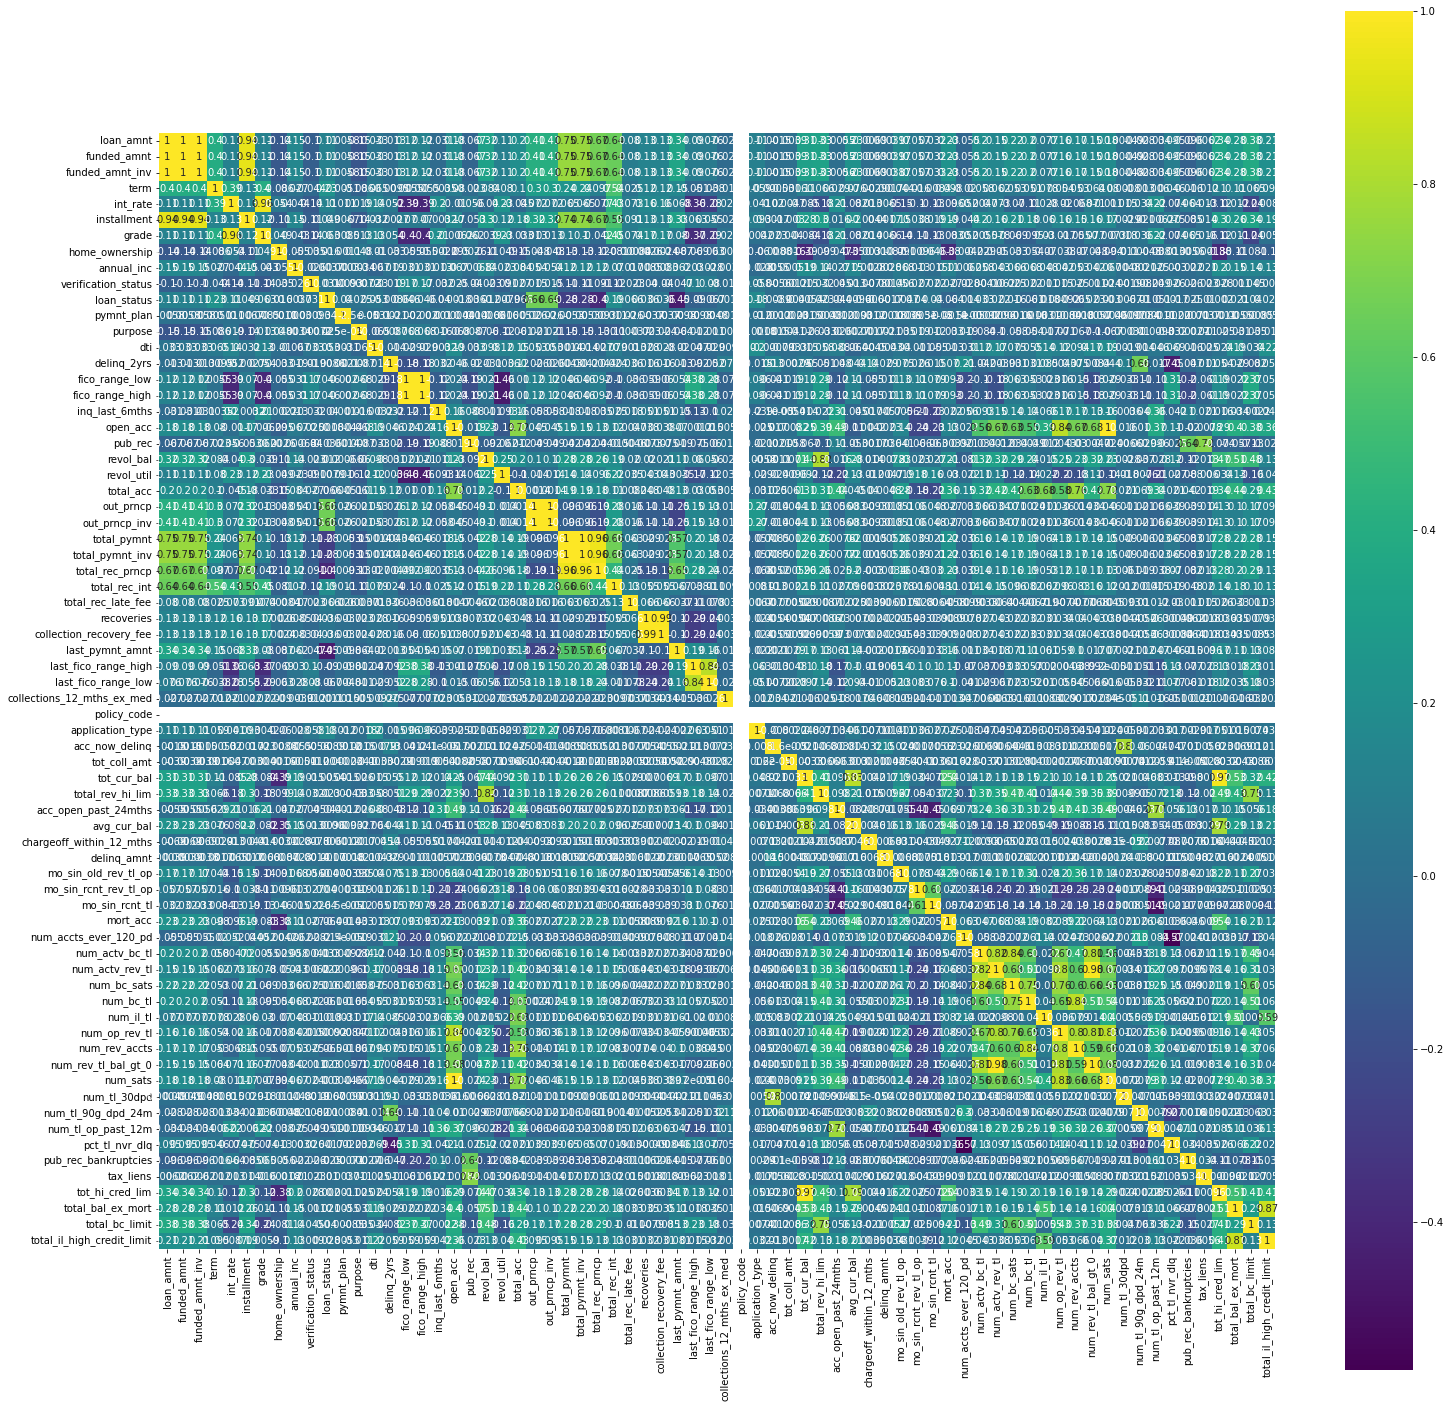

In [96]:
corr = df_nonan.corr()
plt.figure(figsize=(25,25))

sns.heatmap(corr, annot=True, cmap='viridis', square = True)

In [97]:
num_features = corr.shape[0]
columns = np.full((num_features,), True, dtype=bool)

for i in range(num_features):
    for j in range(i+1, num_features):
        if corr.iloc[i,j] >= 0.85:
            if columns[j]:
                columns[j] = False
                

In [98]:
selected_columns = df_nonan.columns[columns]
data = df_nonan[selected_columns]

In [100]:
columns

array([ True, False, False,  True,  True, False, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
       False,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True, False,  True,  True, False])

<AxesSubplot:>

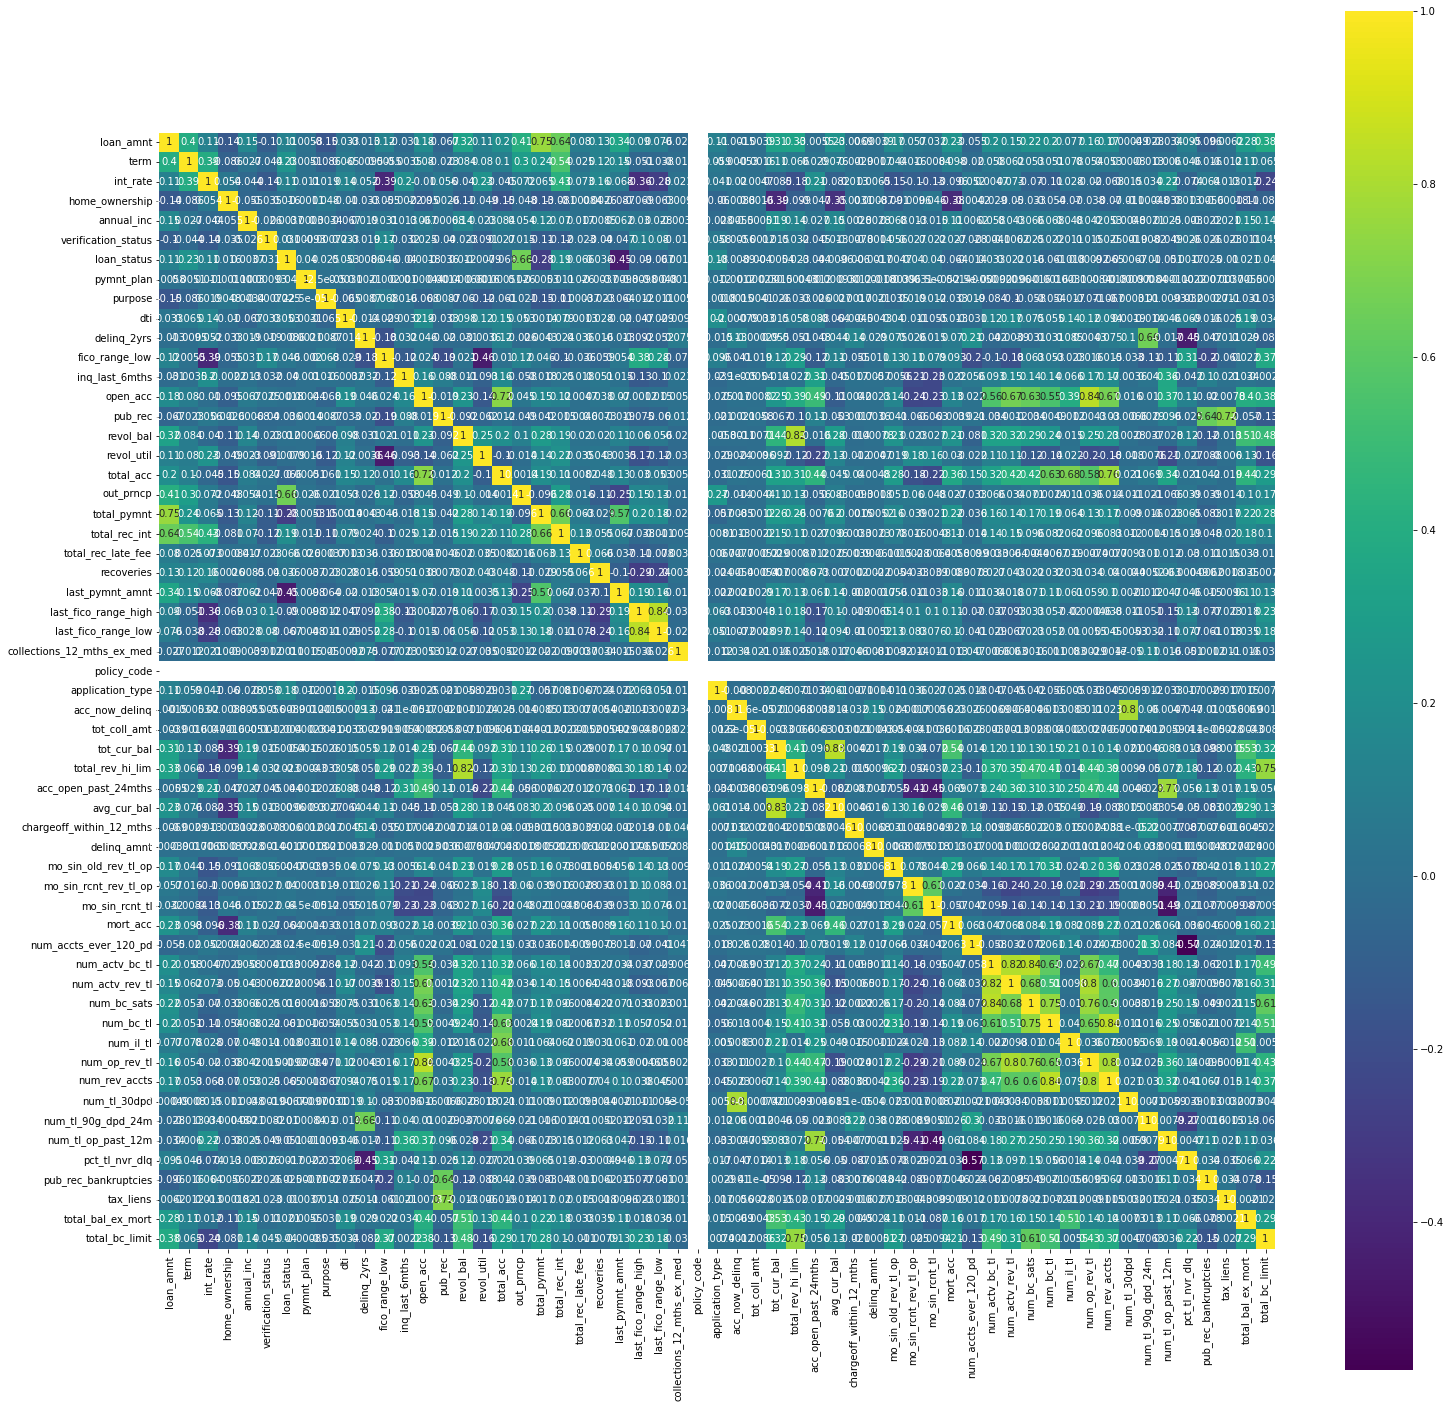

In [101]:
corr = data.corr()
plt.figure(figsize=(25,25))

sns.heatmap(corr, annot=True, cmap='viridis', square = True)

In [130]:
x.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'home_ownership', 'annual_inc',
       'verification_status', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs',
       'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp',
       'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high',
       'last_fico_range_low', 'collections_12_mths_ex_med', 'policy_code',
       'application_type', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal',
       'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_rev_tl_op',
       'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc',
       'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
     